# Analysis of IMAGEN's questionnaires:
1. Demographics
2. Substance use
3. Psychological assessments
4. Socio-economic status

Reference documentation links:
* IMAGEN's native documentation: https://imagen-europe.com/resources/imagen-dataset/documentation/
* Our local documentation: https://github.com/ritterlab/deepMRI/wiki/IMAGEN
* Their github repositories: https://github.com/imagen2
* Evert's initial analysis (lab-rotation): https://github.com/ritterlab/imagen_labrotation
* Evert's thesis: https://github.com/evertdeman/imagen_thesis
* Latest IMAGEN publications: https://imagen-europe.com/resources/publications/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from glob import glob 
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(color_codes=False)

from plotGraphs import plotGraph
from imagen_dataloader import *
# from niwidgets import NiftiWidget

In [3]:
# Specify the path to the data
DATA_DIR = "/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/"
BIDS_DIR = "/ritter/share/data/IMAGEN/IMAGEN_BIDS/"

In [4]:
# ! ls $DATA_DIR/BL
# ! ls $DATA_DIR/BL/psytools

# 1. Demographics

In [25]:
dataset = Imagen()
# dataset.df.info()

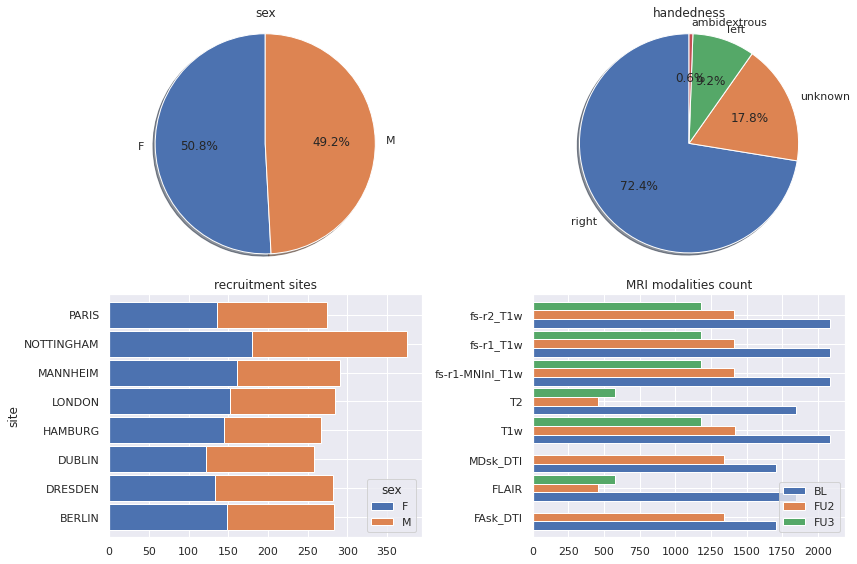

In [26]:
dataset.plot_demographics()

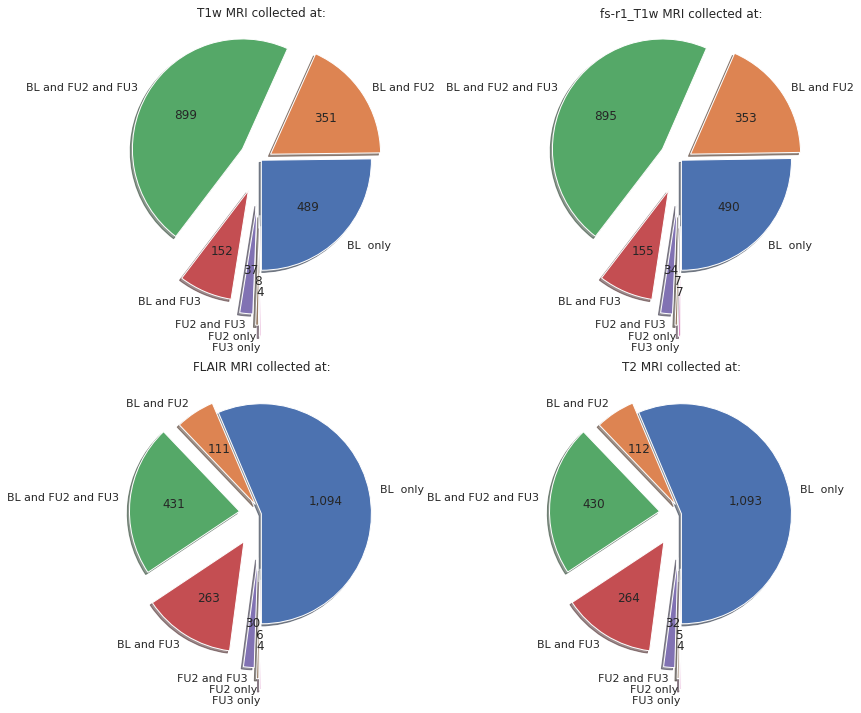

In [7]:
dataset.plot_timepoint_dists()

# 2. Substance use questionnaires
See  the list of IMAGEN questionnaires [here](https://github.com/imagen2/imagen_databank/wiki/Questionnaires)

Analyze the following questionnaires and determine good labels for ML analysis. (verify consistency / estimate noise in labels):
1. AUDIT:	alcohol use disorder identification test
2. ESPAD:	European questionnaire on alcohol, tobacco and other drugs
3. SURPS:	Substance Use Risk Profile Scale
4. MAST:	Michigan Alcoholism Screening Test
5. DAST: 	Drug Abuse Screening Test
5. TLFB: 	Alcohol Timeline Followback
6. LEQ: 	Life-Events Questionnaire

In [9]:
df_demo = pd.read_csv(join(DATA_DIR, "FU3/participants/IMAGEN_demographics.csv"), dtype={"PSC2":int})
df_demo = df_demo.rename(columns={"PSC2" : "ID", "recruitment centre":"site"})
df_demo2 = pd.read_csv(join(DATA_DIR, "IMAGEN_stats_from_db.csv"), sep=";", dtype={"code_in_study":int})
df_demo2 = df_demo2.rename(columns={"code_in_study" : "ID"})[["ID", "gender", "handedness"]]
df_demo = pd.merge(df_demo, df_demo2, on='ID', how="inner")

test_ids = df_demo.loc[df_demo["site"]=="NOTTINGHAM", "ID"]

print("Total subjects in demographics table =", len(df_demo))
print("Total subjects set aside as test set =", len(test_ids))
del df_demo2

Total subjects in demographics table = 2315
Total subjects set aside as test set = 375


## 2.1. AUDIT - Alcohol Use Disorder Identification Test

The questionnaire can be found [here](https://pubs.niaaa.nih.gov/publications/Audit.pdf).
The IMAGEN documentation for the columns in the table can be found [here](https://imagen-europe.com/wp-content/uploads/sites/234/2018/10/WP4_SOP_Annex_instruments_variable_names.pdf) on page 23.

In [73]:
BL = pd.read_csv(qs["AUDIT_BL"], dtype={"User code":str})
BL = BL.assign(time_point = "BL")
FU1 = pd.read_csv(qs["AUDIT_FU1"], dtype={"User code":str})
FU1 = FU1.assign(time_point = "FU1")
FU2 = pd.read_csv(qs["AUDIT_FU2"], dtype={"User code":str})
FU2 = FU2.assign(time_point = "FU2")
FU3 = pd.read_csv(qs["AUDIT_FU3"], dtype={"User code":str})
FU3 = FU3.assign(time_point = "FU3")

# merge all timepoints to a hierarchical table
df_audit = pd.concat([BL, FU1, FU2, FU3])
df_audit["User code"] = df_audit["User code"].apply(lambda x: int(x.replace("-C", "")))
df_audit = df_audit.rename(columns={"User code" : "ID"})
# drop test subjects
df_audit = df_audit[~df_audit["ID"].isin(test_ids)]

del BL, FU1, FU2, FU3
# merge demographic data to this
df_audit = pd.merge(df_audit, df_demo, how="inner")
df_audit = df_audit.set_index(["time_point", "ID"]).sort_index() 
print("Merged AUDIT table")
df_audit

Merged AUDIT table


Iteration Language Completed Completed Timestamp  \
time_point ID                                                           
BL         22453             1       de         t                5365   
           106601            1       fr         t                5060   
           106871            1       de         t                5574   
           112288            1       fr         t                5258   
           240546            1       de         t                5270   
...                        ...      ...       ...                 ...   
FU3        99677574          1       de         t                8197   
           99873252          1       de         t                8370   
           99875982          1       en         t                8123   
           99930021          1       de         t                8129   
           99954902          1       de         t                8468   

                    Processed Timestamp Valid  audit1  audit10  audit2  \
time_point ID                                                            
BL         22453                   5365     t       1      0.0     0.0   
           106601                  5060     t       0      NaN     NaN   
           106871                  5574     t       1      0.0     0.0   
           112288                  5258     t       2      0.0     4.0   
           240546                  5270     t       0      NaN     NaN   
...                                 ...   ...     ...      ...     ...   
FU3        99677574                8197   NaN       1      0.0     0.0   
           99873252                8370   NaN       2      0.0     0.0   
           99875982                8123   NaN       1      0.0     0.0   
           99930021                8129   NaN       2      0.0     0.0   
           99954902                8468   NaN       3      0.0     0.0   

                     audit3  ...  audit_freq  audit_symp  audit_prob  \
time_point ID                ...                                       
BL         22453        0.0  ...           1           2           0   
           106601       NaN  ...           0           0           0   
           106871       0.0  ...           1           0           0   
           112288       1.0  ...           7           0           0   
           240546       NaN  ...           0           0           0   
...                     ...  ...         ...         ...         ...   
FU3        99677574     0.0  ...           1           0           0   
           99873252     1.0  ...           3           0           4   
           99875982     0.0  ...           1           0           0   
           99930021     0.0  ...           2           0           0   
           99954902     1.0  ...           4           1           3   

                     audit_total  audit_abuse_flag  ts_1_specify sex  \
time_point ID                                                          
BL         22453               3                 0           NaN   M   
           106601              0                 0           NaN   M   
           106871              1                 0           NaN   F   
           112288              7                 0           NaN   M   
           240546              0                 0           NaN   M   
...                          ...               ...           ...  ..   
FU3        99677574            1                 0           NaN   F   
           99873252            7                 0           NaN   F   
           99875982            1                 0           NaN   F   
           99930021            2                 0           NaN   F   
           99954902            8                 1           NaN   M   

                         site  gender  handedness  
time_point ID                                      
BL         22453      DRESDEN    male       right  
           106601       PARIS    male        left  
           106871     DRES

AUDIT: Total subjects in each timepoint


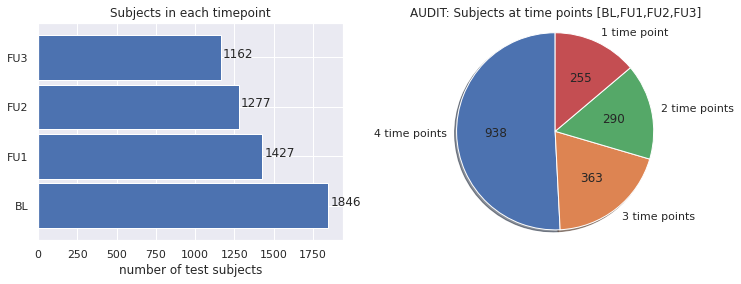

Out of the 2529 subject IDs listed by IMAGEN, 
683 are missing at BL 
1102 are missing at FU1 
1252 are missing at FU2 
1367 are missing at FU3 
in this table


In [11]:
f,axes = plt.subplots(1,2, figsize=(12,4))

print("AUDIT: Total subjects in each timepoint")
plotGraph(df_audit.reset_index(), "time_point", plt_type='barh', title="Subjects in each timepoint", ax=axes[0])

(df_audit.reset_index()['ID'].value_counts()).value_counts().plot.pie(
    ax=axes[1], labels = ["4 time points","3 time points","2 time points","1 time point"],
    title="AUDIT: Subjects at time points [BL,FU1,FU2,FU3]", autopct=lambda p : '{:,.0f}'.format(p*len(df_audit.loc['BL'])/100), 
    shadow=True, startangle=90, ylabel='')
axes[1].axis('equal')
plt.show()

# make a list of subjects missing data at different timepoints in the table
with open(join(DATA_DIR, "../documentation/Valid-identifiers.txt")) as f:
    valid_ids = set([int(i) for i in f])

missing_BL_audit = (valid_ids - set(df_audit.loc["BL"].index))
missing_FU1_audit = (valid_ids - set(df_audit.loc["FU1"].index))
missing_FU2_audit = (valid_ids - set(df_audit.loc["FU2"].index))
missing_FU3_audit = (valid_ids - set(df_audit.loc["FU3"].index))
print("Out of the {} subject IDs listed by IMAGEN, \
\n{} are missing at BL \n{} are missing at FU1 \n{} are missing at FU2 \n{} are missing at FU3 \nin this table".format(
len(valid_ids), len(missing_BL_audit), len(missing_FU1_audit), len(missing_FU2_audit), len(missing_FU3_audit)))

Total AUDIT score (out of 40):


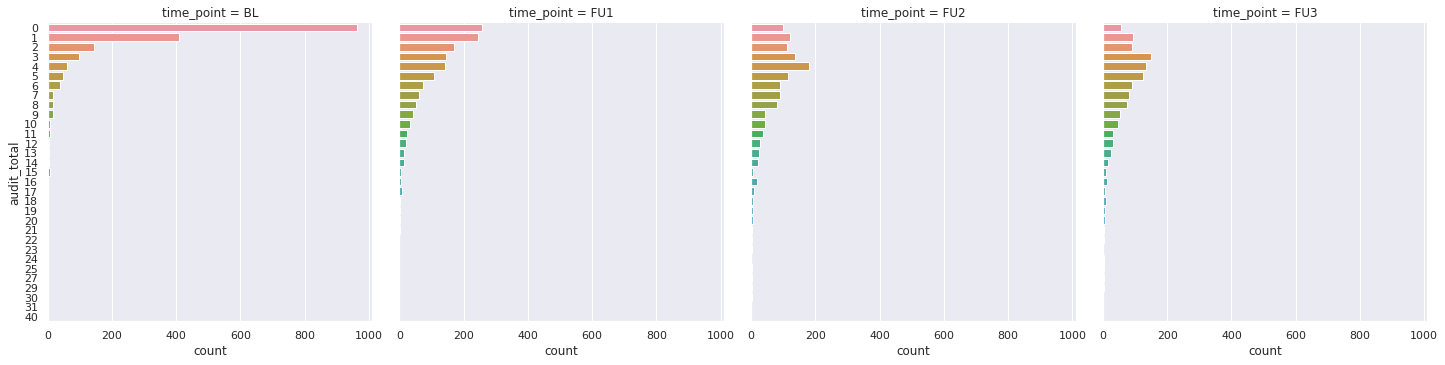

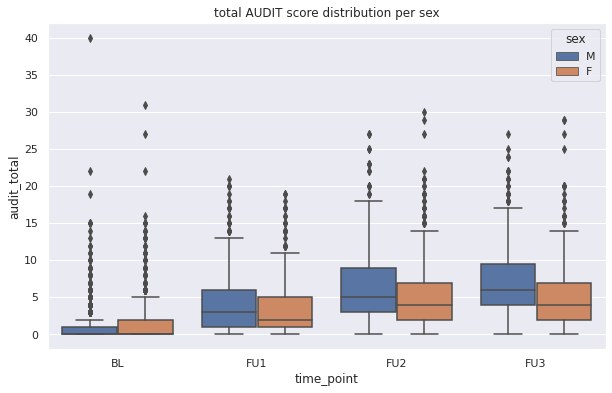

In [12]:
print("Total AUDIT score (out of 40):")
sns.catplot(data=df_audit.reset_index(), y='audit_total', col='time_point', kind='count') 

# box plot distribution of the same data
plt.figure(figsize=(10,6))
plt.title("total AUDIT score distribution per sex")
sns.boxplot(data=df_audit.reset_index(), x='time_point', y='audit_total', hue="sex")
plt.show()

In [12]:
# print("Info: If a respondent indicates they are under watch, being helped at the task, are being rushed, etc. the psytools sets the flag 'Valid' to false for a measurement.")
# plotGraph(df_audit, "Valid", plt_type='pie')
# plotGraph(df_audit, "Language", plt_type='barh', dropna=True)

--------------------------------------------------------------
 Baseline (BL) at age 14:


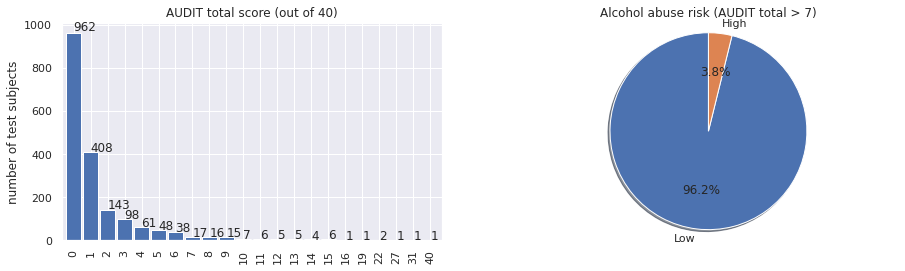

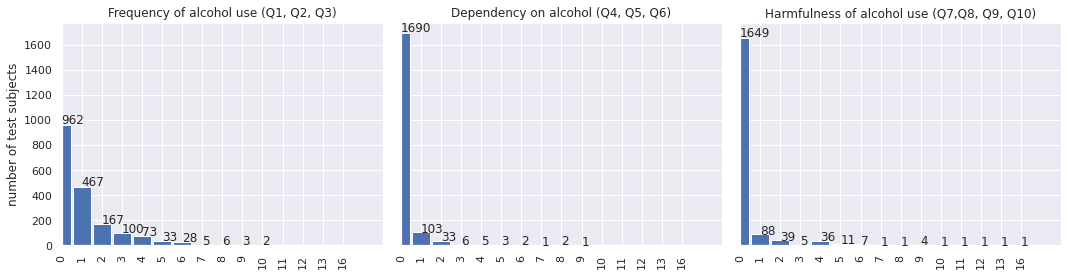

--------------------------------------------------------------
 Follow up 1 (FU1) at age 16:


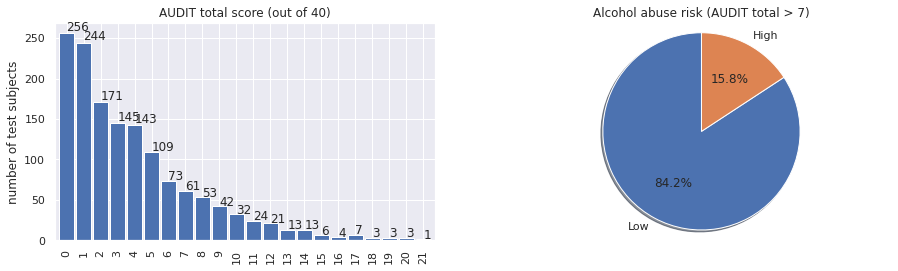

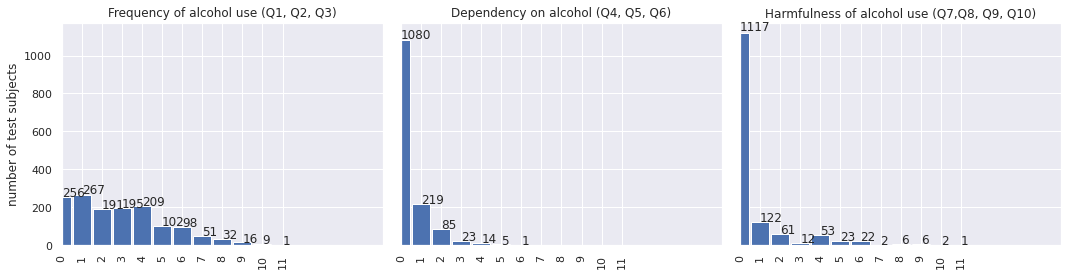

--------------------------------------------------------------
 Follow up 2 (FU2) at age 19:


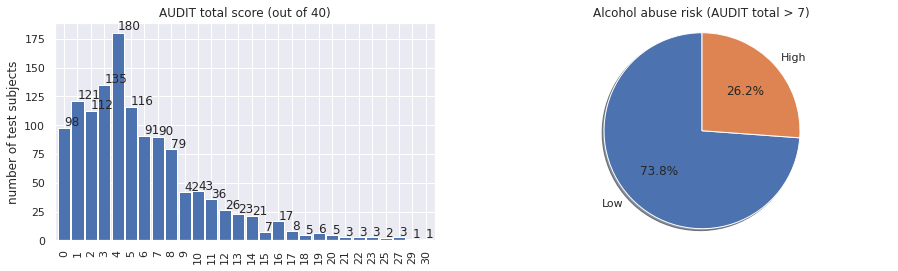

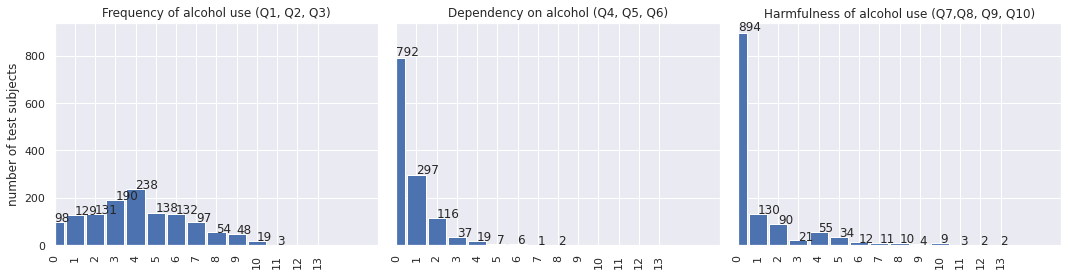

--------------------------------------------------------------
 Follow up 3 (FU3) at age 21:


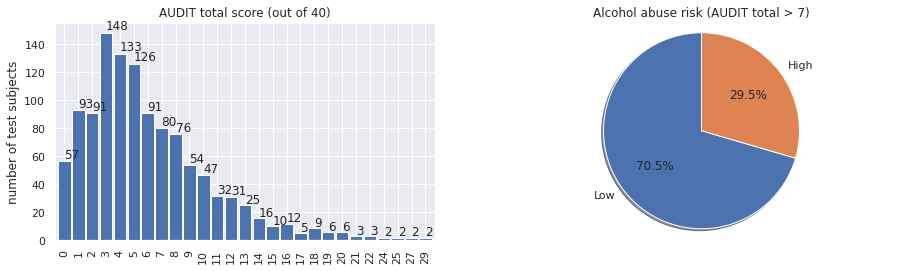

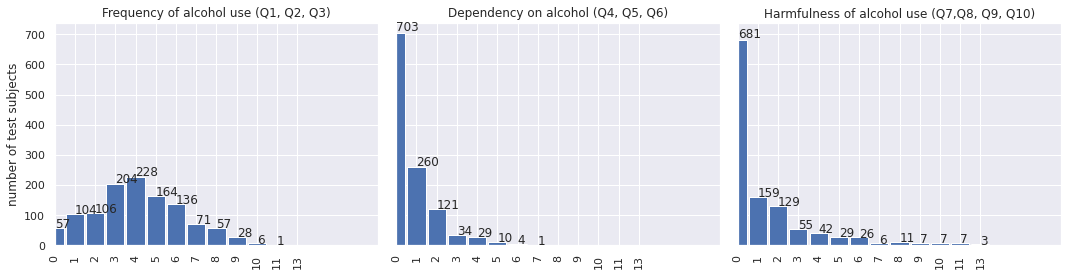

In [12]:
########################################################################
def plot_audit(dfi):
    f, [ax1,ax2] = plt.subplots(1,2, figsize=(15, 4))
    plotGraph(dfi, "audit_total", plt_type='bar', ax=ax1, title="AUDIT total score (out of 40)")
    dfi = dfi.replace({"audit_abuse_flag": {0:"Low", 1:"High"}})
    plotGraph(dfi, "audit_abuse_flag", plt_type='pie', ax=ax2, title="Alcohol abuse risk (AUDIT total > 7)")
    f, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(15, 4), sharex=True, sharey=True)
    # split the questionnaire into 3 sub types
    plotGraph(dfi, "audit_freq", plt_type='bar', ax=ax1, title="Frequency of alcohol use (Q1, Q2, Q3)")
    ax1.set_xlim(0,12)
    plotGraph(dfi, "audit_symp", plt_type='bar', ax=ax2, title="Dependency on alcohol (Q4, Q5, Q6)")
    ax2.set_xlim(0,12)
    plotGraph(dfi, "audit_prob", plt_type='bar', ax=ax3, title="Harmfulness of alcohol use (Q7,Q8, Q9, Q10)")
    ax2.set_xlim(0,16)
    plt.tight_layout()
    plt.show()
    
print("--------------------------------------------------------------\n \
Baseline (BL) at age 14:")
plot_audit(df_audit.loc["BL"])
print("--------------------------------------------------------------\n \
Follow up 1 (FU1) at age 16:")
plot_audit(df_audit.loc["FU1"])
print("--------------------------------------------------------------\n \
Follow up 2 (FU2) at age 19:")
plot_audit(df_audit.loc["FU2"])
print("--------------------------------------------------------------\n \
Follow up 3 (FU3) at age 21:")
plot_audit(df_audit.loc["FU3"])

### 2.1.3 Comparing AUDIT, AUDIT-C (1,2,3 questions) and AUDIT-q3
From [Henry et al. 2018](10.1001/jama.2018.11406)

" For detecting __heavy alcohol use__ (defined as Binge drinking on 5 or more days in the past month): 
1. For AUDIT    score >= 4 : sensitivity of 84%-85% and specificity of 77%-84%
2. For AUDIT    score >= 5 : sensitivity of 70%-92% and specificity of 73%-94%
3. For AUDIT-C  score >= 4 : sensitivity of 74%-76% and specificity of 80%-83%
4. For AUDIT-C  score >= 3 : sensitivity of 74%-88% and specificity of 64%-83% 
5. For AUDIT-q3 score >= 1 : sensitivity of 82%-87% and specificity of 61%-79%
"

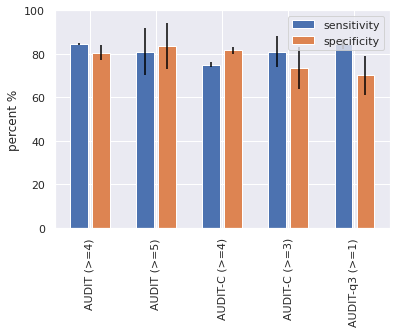

In [13]:
sensitivity = np.array([      (84,85),      (70,92),         (74,76),        (74, 88),           (82,87)])
specificity = np.array([      (77,84),      (73,94),         (80,83),        (64, 83),           (61,79)])
x=                      ["AUDIT (>=4)", "AUDIT (>=5)", "AUDIT-C (>=4)", "AUDIT-C (>=3)", "AUDIT-q3 (>=1)"]
x_i = np.arange(len(x))*3

mean_sens = sensitivity.mean(axis=1)
stdd_sens = sensitivity[:,1] - mean_sens
# sensitivity = sensitivity-mean_sens
plt.bar(x_i-0.5, mean_sens, yerr=stdd_sens, label="sensitivity")

mean_spec = specificity.mean(axis=1)
stdd_spec = specificity[:,1] - mean_spec
# sensitivity = sensitivity-mean_spec
plt.bar(x_i+0.5, mean_spec, yerr=stdd_spec, label="specificity")

plt.xticks(ticks=x_i, labels=x, rotation=90)
plt.ylim(0,100)
plt.ylabel("percent %")
plt.legend(loc='upper right')
plt.show()

## 2.2 ESPAD

The questionnaire can be found [here](http://www.espad.org/sites/espad.org/files/espad-master-questionnaire.pdf). The ESPAD is an alcohol, nicotine and other illicit drugs questionnaire. 

In [45]:
# Read in the data
BL = pd.read_csv(qs["ESPAD_BL"], sep=",", dtype={"User code":str, "Valid":str})
BL = BL.assign(time_point = "BL")
FU1 = pd.read_csv(qs["ESPAD_FU1"], sep=",", dtype={"User code":str, "Valid":str})
FU1 = FU1.assign(time_point = "FU1")
FU2 = pd.read_csv(qs["ESPAD_FU2"], sep=",", dtype={"User code":str, "Valid":str})
FU2 = FU2.assign(time_point = "FU2")
FU3 = pd.read_csv(qs["ESPAD_FU3"], sep=",", dtype={"User code":str, "Valid":str})
FU3 = FU3.assign(time_point = "FU3")


espad = pd.concat([BL, FU1, FU2, FU3])
espad["User code"] = espad["User code"].apply(lambda x: int(x.replace("-C", "")))
espad = espad.rename(columns={"User code" : "ID"})
# drop test subjects from analysis to avoid analysis bias
espad = espad[~espad["ID"].isin(test_ids)]
del BL, FU1, FU2, FU3

#filter only the questions regarding alcohol since there are >1k columns
espad = espad[["ID", "time_point", 
               "8a", "8b", "8c", "9a", "9b", "9c", "9d", "17a", "17b", "17c",
               "29beer", "29wine", "29alcopop", "29spirits",
               "prev31", "19a", "19b", "19c", "29d", "20", "21"]]
# merge demographic data to this
espad = pd.merge(espad, df_demo, how="inner")
espad = espad.set_index(["time_point","ID"]).sort_index() #pd.MultiIndex.from_frame(df_audit[["ID", "time_point"]])
print("Merged and filtered ESPAD table:")
espad

/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (105,125,140,166,168,170,185,236,244) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (84,140,158,174,190,191,195,218,220,221,287,298) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Merged and filtered ESPAD table:


8a   8b   8c   9a   9b   9c   9d  17a  17b  17c  ...  \
time_point ID                                                         ...   
BL         22453      1  1.0  0.0  0.0  1.0  1.0  0.0  2.0  1.0  0.0  ...   
           106601     0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
           106871     1  0.0  NaN  0.0  0.0  0.0  0.0  0.0  NaN  NaN  ...   
           112288     6  3.0  2.0  2.0  1.0  1.0  2.0  3.0  3.0  2.0  ...   
           240546     0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
...                  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
FU3        99677574   3  1.0  0.0  NaN  NaN  NaN  NaN  0.0  NaN  NaN  ...   
           99873252   6  5.0  2.0  1.0  2.0  1.0  1.0  5.0  5.0  2.0  ...   
           99875982   4  2.0  1.0  1.0  0.0  0.0  0.0  3.0  0.0  NaN  ...   
           99930021   1  1.0  1.0  1.0  1.0  0.0  4.0  3.0  0.0  NaN  ...   
           99954902   6  6.0  4.0  4.0  0.0  0.0  2.0  4.0  1.0  1.0  ...   

                     19a  19b  19c   29d   20   21  sex      site  gender  \
time_point ID                                                               
BL         22453     1.0  1.0  0.0  13.0  7.0  5.0    M   DRESDEN    male   
           106601    NaN  NaN  NaN   NaN  NaN  NaN    M     PARIS    male   
           106871    0.0  NaN  NaN   NaN  NaN  NaN    F   DRESDEN  female   
           112288    0.0  NaN  NaN   NaN  NaN  NaN    M     PARIS    male   
           240546    NaN  NaN  NaN   NaN  NaN  NaN    M    BERLIN    male   
...                  ...  ...  ...   ...  ...  ...  ...       ...     ...   
FU3        99677574  0.0  NaN  NaN   NaN  NaN  NaN    F    BERLIN  female   
           99873252  6.0  5.0  2.0  15.0  7.0  2.0    F    BERLIN  female   
           99875982  1.0  0.0  NaN  18.0  8.0  3.0    F    LONDON  female   
           99930021  2.0  0.0  NaN  16.0  6.0  3.0    F  MANNHEIM  female   
           99954902  5.0  2.0  2.0  16.0  3.0  2.0    M   HAMBURG    male   

                     handedness  
time_point ID                    
BL         22453          right  
           106601          left  
           106871         right  
           112288         right  
           240546         right  
...                         ...  
FU3        99677574       right  
           99873252       right  
           99875982       right  
           99930021       right  
           99954902       right  

[5700 rows x 25 columns]

In [ ]:
f,axes = plt.subplots(1,2, figsize=(12,4))

print("ESPAD: Total subjects in each timepoint")
plotGraph(espad.reset_index(), "time_point", plt_type='barh', title="Subjects in each timepoint", ax=axes[0])


(espad.reset_index()['ID'].value_counts()).value_counts().plot.pie(
    ax=axes[1], labels = ["4 time points","3 time points","2 time points","1 time point"],
    title="ESPAD: Subjects at time points [BL,FU1,FU2,FU3]", autopct=lambda p : '{:,.0f}'.format(p*len(espad.loc['BL'])/100), 
    shadow=True, startangle=90, ylabel='')
axes[1].axis('equal')
plt.show()

# make a list of subjects missing data at different timepoints in the table
with open(join(DATA_DIR, "../documentation/Valid-identifiers.txt")) as f:
    valid_ids = set([int(i) for i in f])

missing_BL_espad = (valid_ids - set(espad.loc["BL"].index))
missing_FU1_espad = (valid_ids - set(espad.loc["FU1"].index))
missing_FU2_espad = (valid_ids - set(espad.loc["FU2"].index))
missing_FU3_espad = (valid_ids - set(espad.loc["FU3"].index))
print("Out of the {} subject IDs listed by IMAGEN, \
\n{} are missing at BL \n{} are missing at FU1 \n{} are missing at FU2 \n{} are missing at FU3 \nin this table".format(
len(valid_ids), len(missing_BL_espad), len(missing_FU1_espad), len(missing_FU2_espad), len(missing_FU3_espad)))

### 2.2.1 Alcohol consumption frequency/ quantity questions

* 8a 'On how many occasions IN YOUR WHOLE LIFETIME have you had any alcoholic beverage to drink?'
* 8b 'On how many occasions OVER THE LAST 12 MONTHS have you had any alcoholic beverage to drink?'
* 8c 'On how many occasions OVER THE LAST 30 DAYS have you had any alcoholic beverage to drink?'
* prev31 'How many drinks containing alcohol do you have on a TYPICAL DAY when you are drinking?'

In [10]:
df = espad.reset_index().fillna(-1)

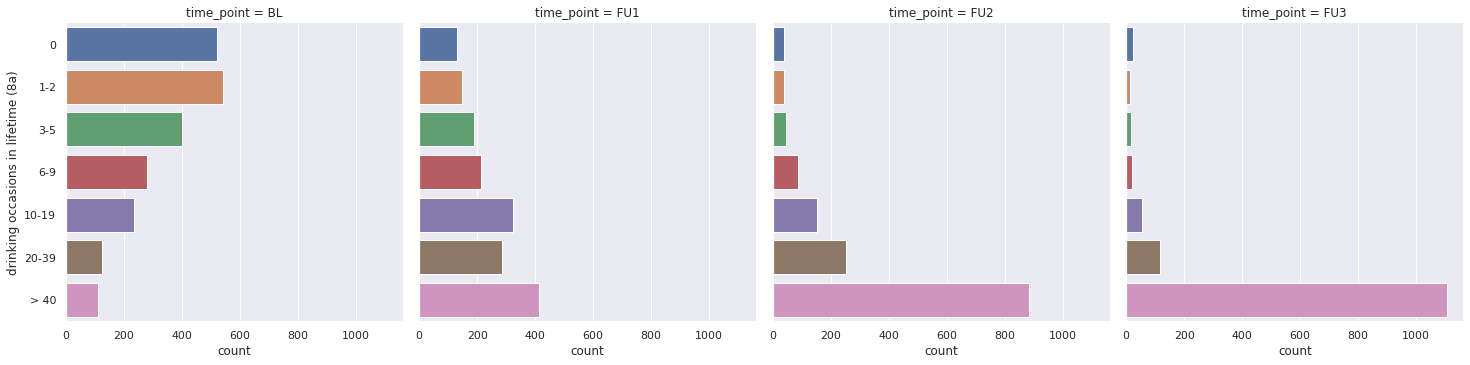

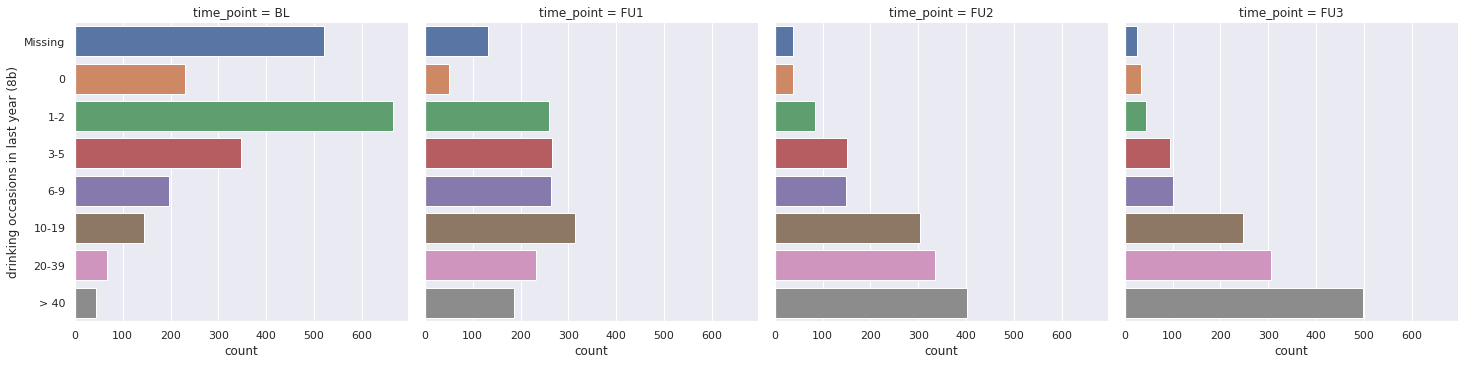

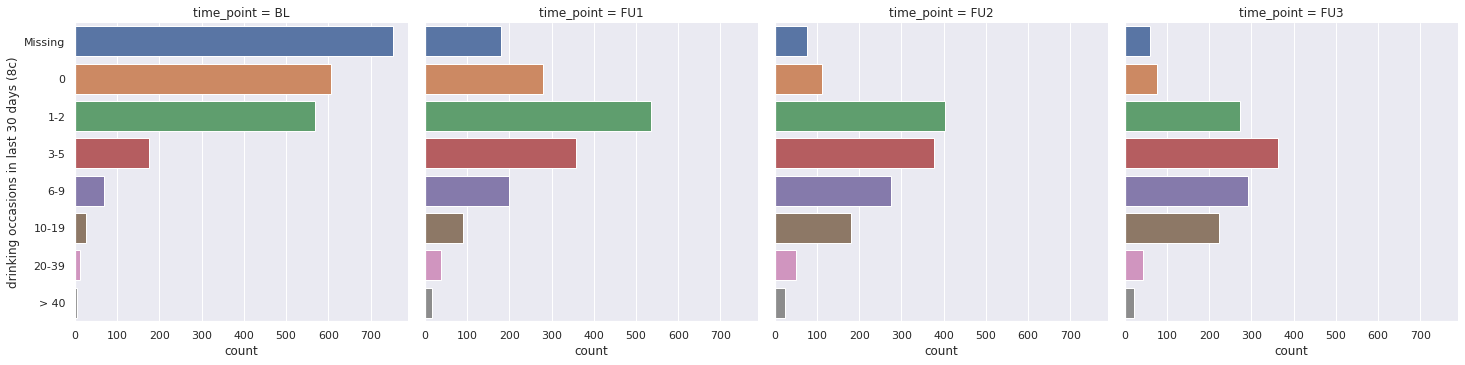

In [12]:
remapvalues_8x = { -1:"Missing", 0:'0',1:'1-2',2:'3-5',3:'6-9',4:'10-19',5:'20-39',6:'> 40'}
# questions on total drinks consumed
g = sns.catplot(data=df, y="8a", col='time_point', kind='count') 
g.set_ylabels("drinking occasions in lifetime (8a)")
g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

g = sns.catplot(data=df, y="8b", col='time_point', kind='count') 
g.set_ylabels("drinking occasions in last year (8b)")
g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

g = sns.catplot(data=df, y="8c", col='time_point', kind='count') 
g.set_ylabels("drinking occasions in last 30 days (8c)")
g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

plt.show()

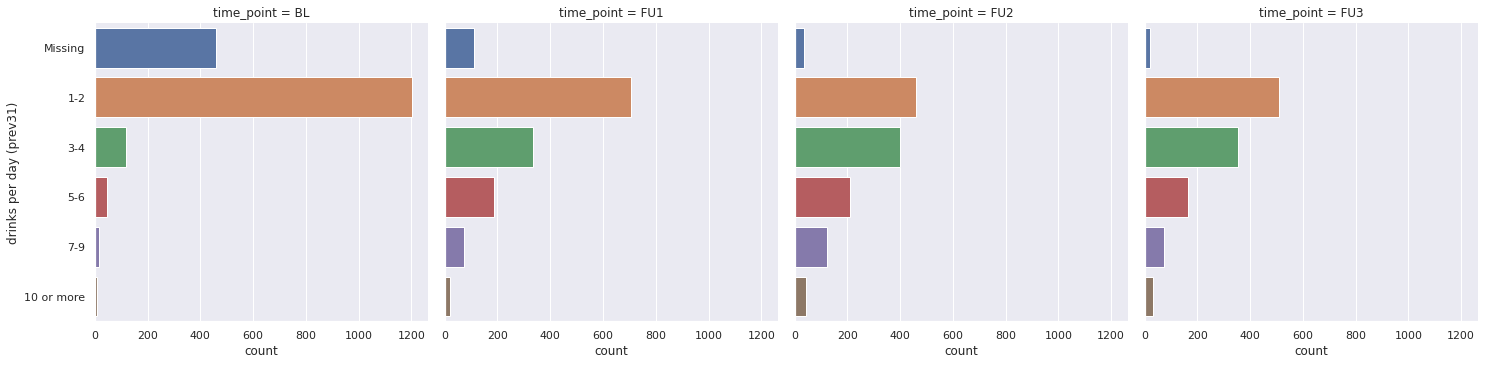

In [28]:
remapvalues_31 = { -1:"Missing", 1:'1-2', 2:'3-4', 3:'5-6', 4:'7-9', 5:'10 or more'}

g = sns.catplot(data=df, y="prev31", col='time_point', kind='count') 
g.set_yticklabels([remapvalues_31[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])
g.set_ylabels("drinks per day (prev31)")
plt.show()

### 2.2.2 Binge drinking
* 17a 'How many times IN YOUR WHOLE LIFETIME have you had five or more drinks in a row?'
* 17b 'How many times OVER THE LAST 12 MONTHS have you had five or more drinks in a row?'
* 17c 'How many times OVER THE LAST 30 DAYS have you had five or more drinks in a row?'
* 19a 'On how many occasions IN YOUR WHOLE LIFETIME have you been drunk from drinking alcoholic beverages?'
* 19b 'On how many occasions OVER THE LAST 12 MONTHS have you been drunk from drinking alcoholic beverages?'.
* 19c 'On how many occasions OVER THE LAST 30 DAYS have you been drunk from drinking alcoholic beverages?'.
* 20 'Please indicate on this scale from 1 to 10 how drunk you would say you were the last time you were drunk.'.
* 21 'How many drinks do you usually need to get drunk?

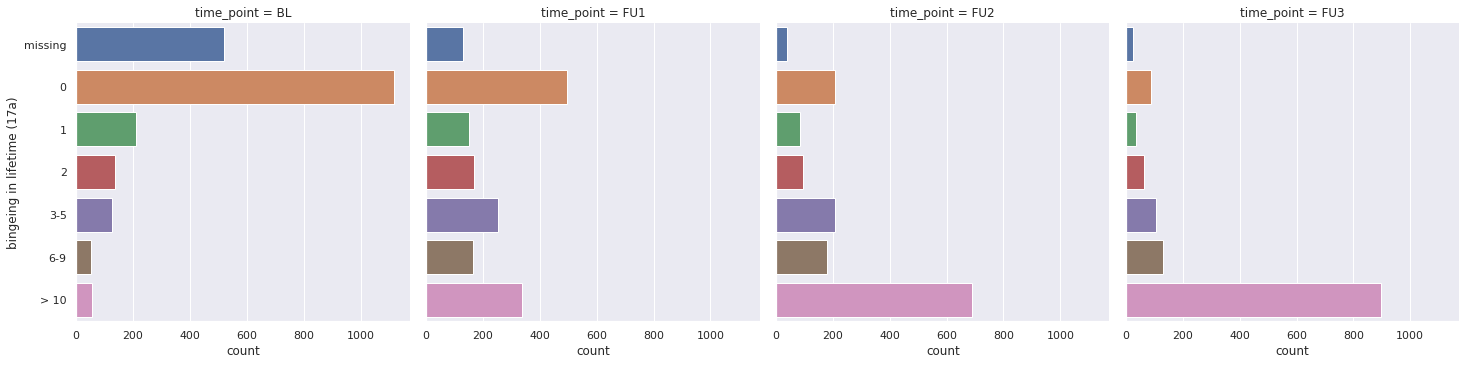

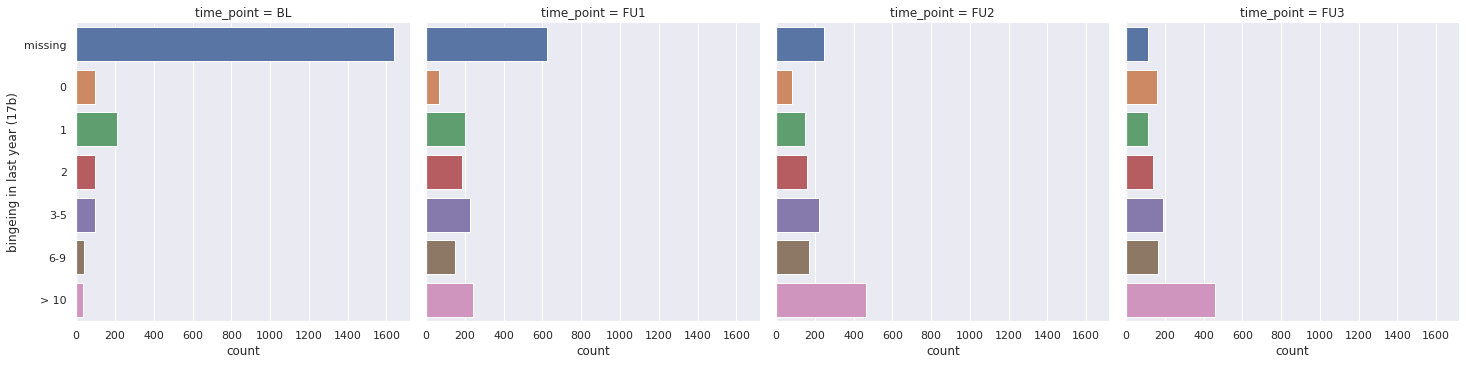

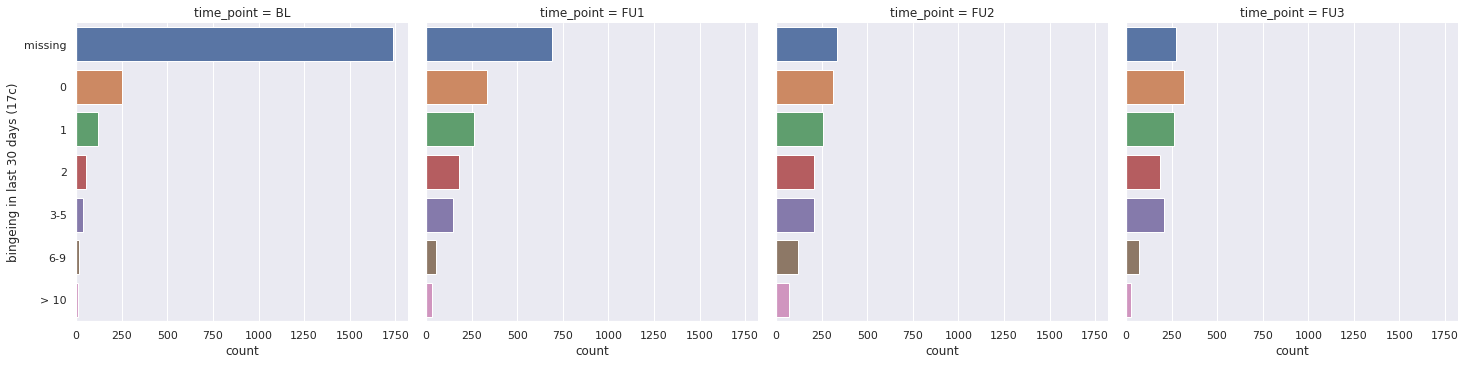

In [11]:
remapvalues_17x = {0:'0',1:'1',2:'2',3:'3-5',4:'6-9',5:'> 10', -1:"missing"}

# questions on total bingeing experiences
g = sns.catplot(data=df, y="17a", col='time_point', kind='count') 
g.set_ylabels("bingeing in lifetime (17a)")
g.set_yticklabels([remapvalues_17x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

g = sns.catplot(data=df, y="17b", col='time_point', kind='count') 
g.set_ylabels("bingeing in last year (17b)")
g.set_yticklabels([remapvalues_17x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

g = sns.catplot(data=df, y="17c", col='time_point', kind='count') 
g.set_ylabels("bingeing in last 30 days (17c)")
g.set_yticklabels([remapvalues_17x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

plt.show()

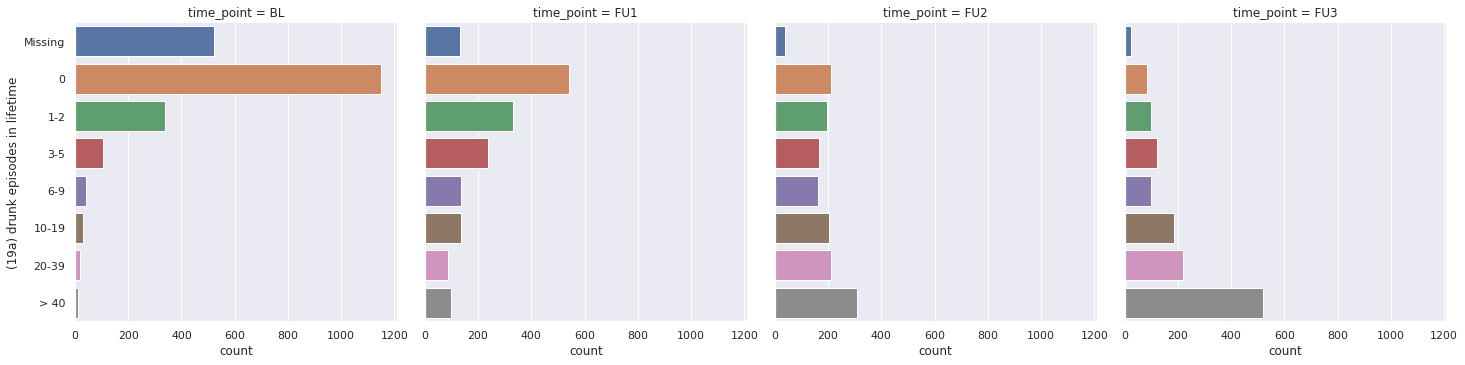

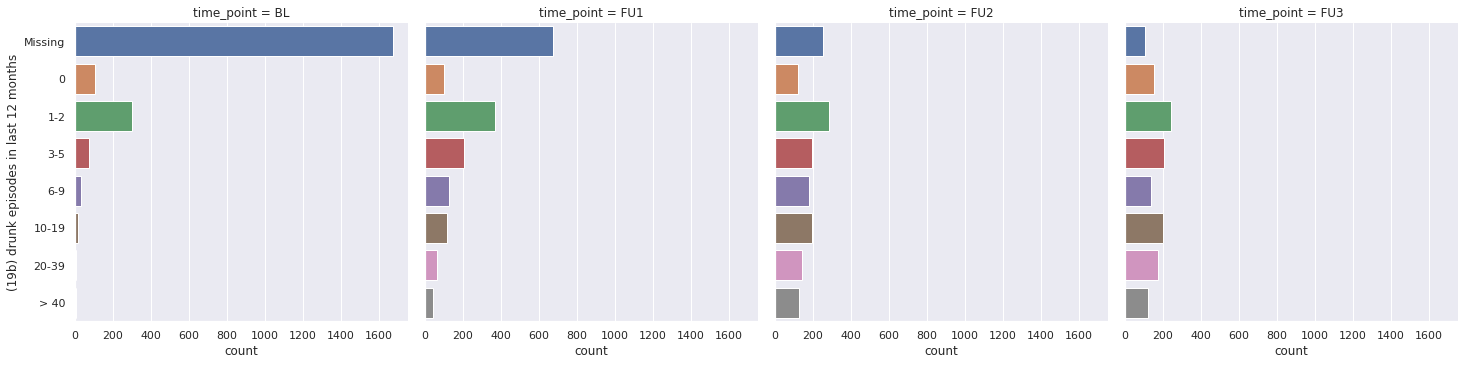

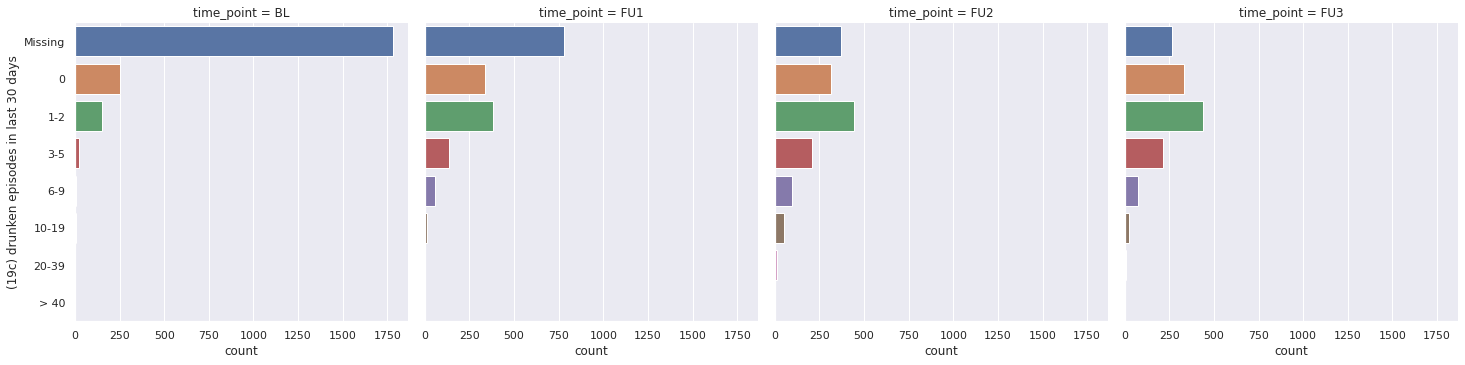

In [21]:
g = sns.catplot(data=df, y="19a", col='time_point', kind='count') 
g.set_ylabels("(19a) drunk episodes in lifetime")
g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

g = sns.catplot(data=df, y="19b", col='time_point', kind='count') 
g.set_ylabels("(19b) drunk episodes in last 12 months")
g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

g = sns.catplot(data=df, y="19c", col='time_point', kind='count') 
g.set_ylabels("(19c) drunken episodes in last 30 days")
g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

plt.show()

#### 2.2.2.1 Comparing the 2 ESPAD questions of lifetime binging for consistency

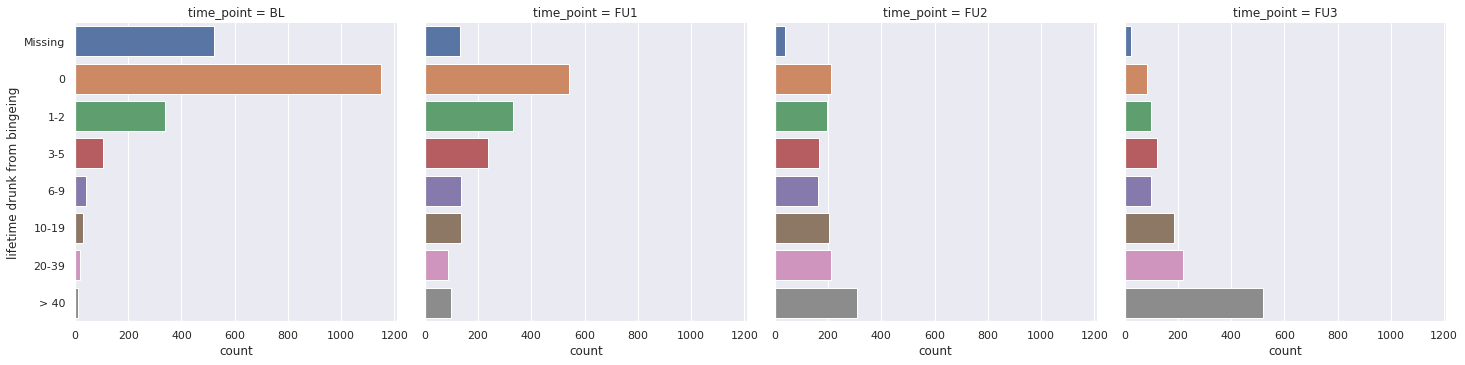

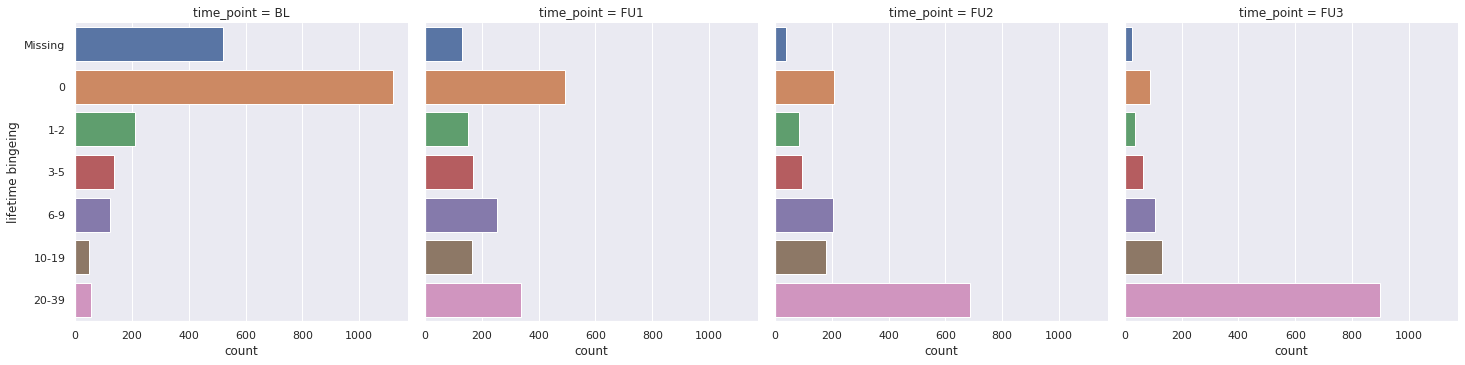

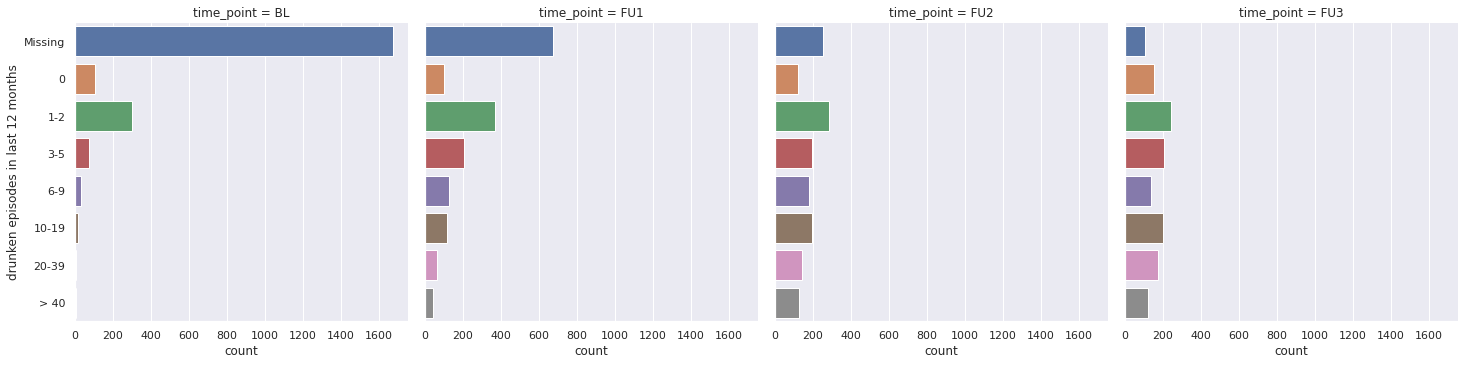

In [15]:
g = sns.catplot(data=df, y="19a", col='time_point', kind='count') 
g.set_ylabels("lifetime drunk from bingeing")
g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

g = sns.catplot(data=df, y="17a", col='time_point', kind='count') 
g.set_ylabels("lifetime bingeing")
g.set_yticklabels([remapvalues_17x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

plt.show()

### 2.2.3 Onset questions
* 29d 'When did you FIRST get drunk from drinking alcoholic beverages?'.
* 29beer 'When did you FIRST drink beer (at least one glass)?'
* 29wine 'When did you FIRST drink wine (at least one glass)?'
<!-- * 29alcopop 'When did you FIRST drink alcopops (at least one bottle)?'
* 29spirits 'When did you FIRST drink spirits (at least one glass)?' -->

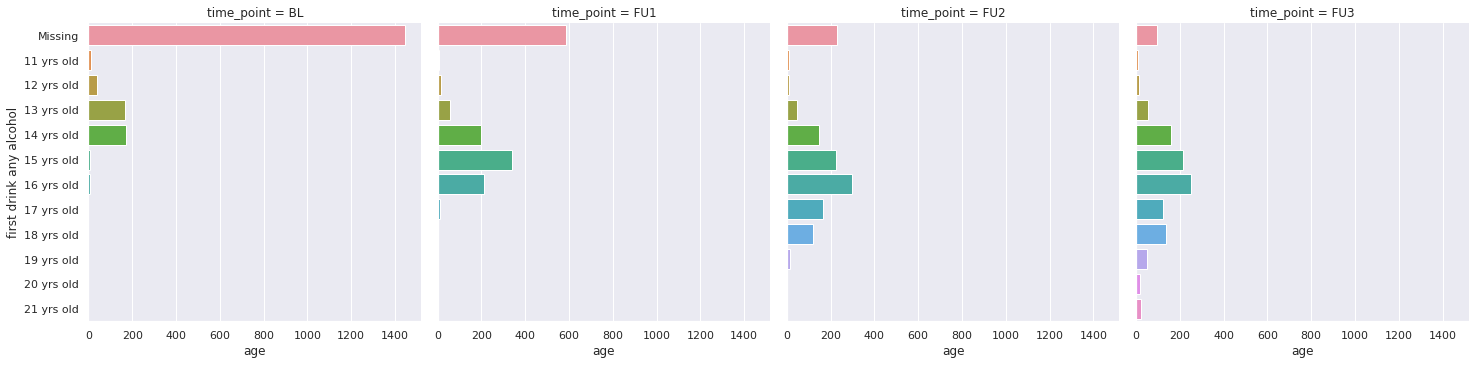

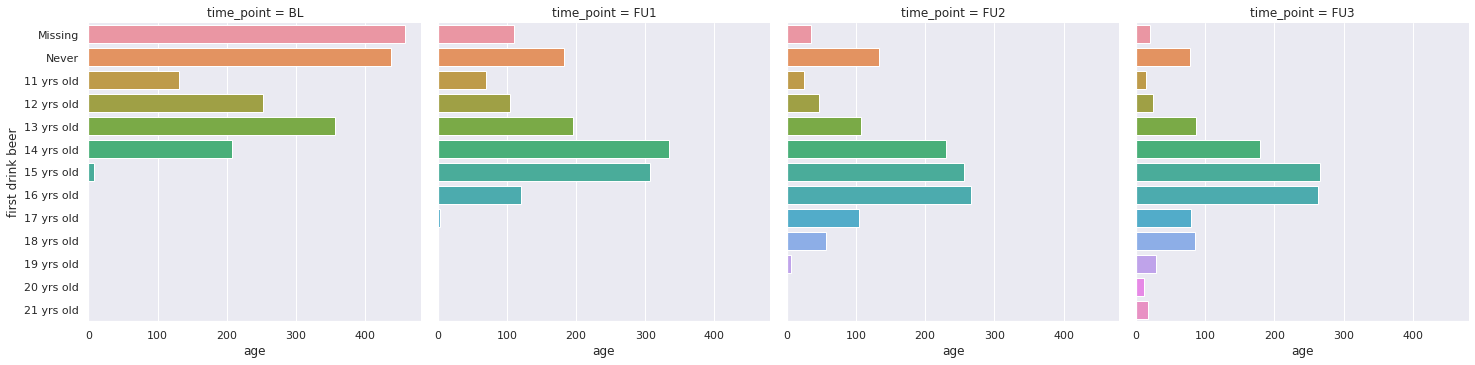

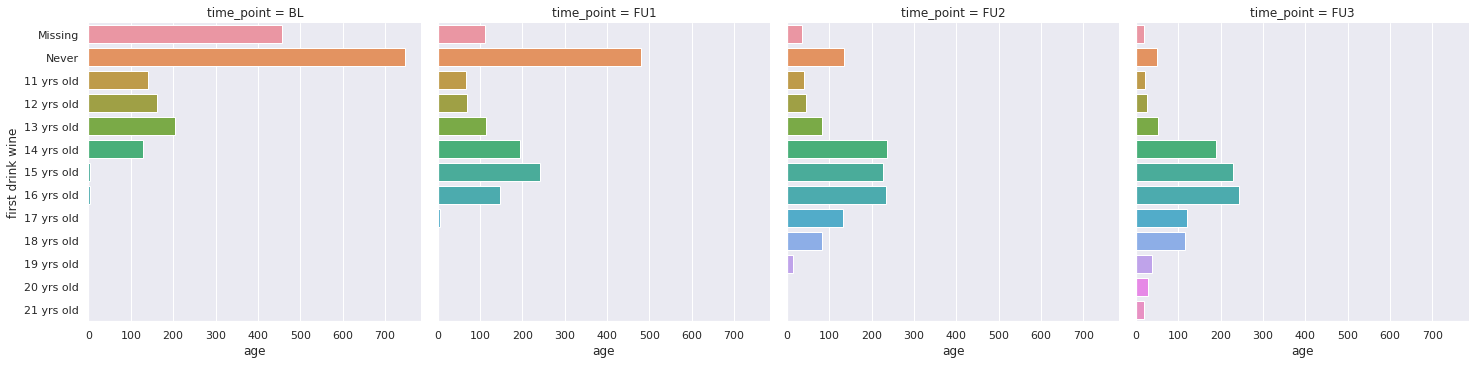

In [20]:
def remapvalues_29x(t):
    if t==-1:
        return "Missing"
    elif t==0:
        return "Never"
    elif t>0:
        return "{} yrs old".format(int(t))
    else:
        return "{} ??".format(t)

g = sns.catplot(data=df, y="29d", col='time_point', kind='count') 
g.set_axis_labels("age", "first drink any alcohol")
g.set_yticklabels([remapvalues_29x(float(t.get_text())) for t in g.axes[0][0].get_yticklabels()])

g = sns.catplot(data=df, y="29beer", col='time_point', kind='count') 
g.set_axis_labels("age", "first drink beer")
g.set_yticklabels([remapvalues_29x(float(t.get_text())) for t in g.axes[0][0].get_yticklabels()])

g = sns.catplot(data=df, y="29wine", col='time_point', kind='count') 
g.set_axis_labels("age", "first drink wine")
g.set_yticklabels([remapvalues_29x(float(t.get_text())) for t in g.axes[0][0].get_yticklabels()])

# g = sns.catplot(data=df, y="29spirits", col='time_point', kind='count') 
# g.set_axis_labels("age", "first drink spirits")
# g.set_yticklabels([remapvalues_29x(float(t.get_text())) for t in g.axes[0][0].get_yticklabels()])

# g = sns.catplot(data=df, y="29alcopop", col='time_point', kind='count') 
# g.set_axis_labels("age", "first drink alcopop")
# g.set_yticklabels([remapvalues_29x(float(t.get_text())) for t in g.axes[0][0].get_yticklabels()])

plt.show()

##### 2.2.4.1 Inconsistencies in first-time-use data

Observation:
Subjects reporting that they had their first drink at 13 are very inconsistent across timepoints:


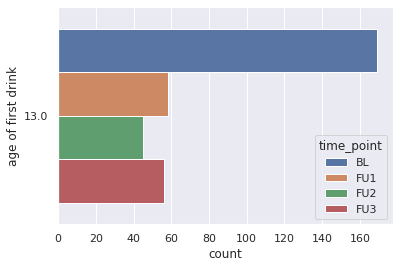

what had the subjects from FU1, FU2 and FU3 said at BL?


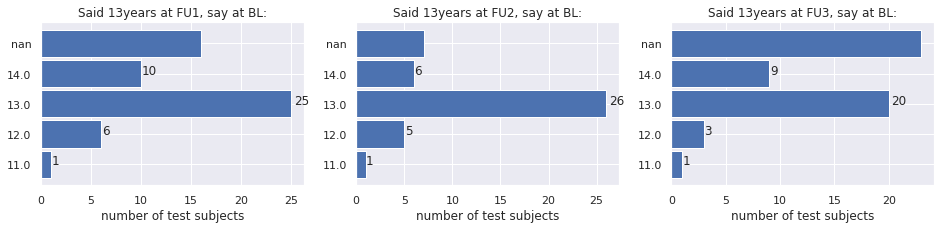

what did the 169 subjects from BL say at FU1, FU2 and FU3?


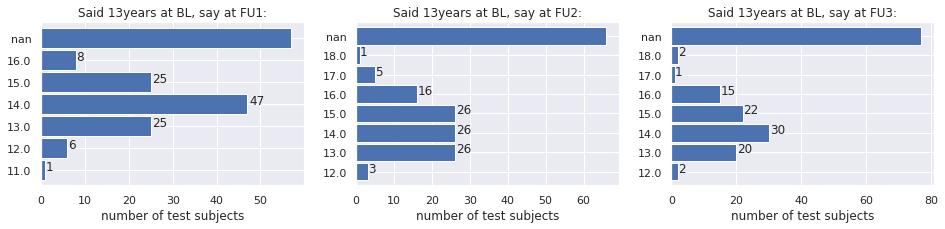

In [21]:
print("Observation:\nSubjects reporting that they had their first drink at 13 are very inconsistent across timepoints:")
ax = sns.countplot(data=df[df["29d"]==13], y="29d", hue='time_point') 
ax.set_ylabel("age of first drink")
plt.show()
# At BL (age 14), {} reported that they had their first drink at 13. \
# But at FU2 (age 19), only {} reported that they had their first drink at 13. \
# Does this mean that the subjects report inconsistently? \
# Or did {} subjects who reported having their first drink at 13 drop out by FU2?".format(
# len(bl_13), (fu2==13.0).sum(), (bl==13.0).sum()-(fu2==13.0).sum()))

bl=(espad.loc["BL","29d"])
fu1=(espad.loc["FU1","29d"])
fu2=(espad.loc["FU2","29d"])
fu3=(espad.loc["FU3","29d"])
bl_13 = set(bl[bl==13.0].index)
fu1_13 = set(fu1[fu1==13.0].index)
fu2_13 = set(fu2[fu2==13.0].index)#-set([45234090]) #this one subject was not in BL and only joined in in FU2 ?!?!?!
fu3_13 = set(fu3[fu3==13.0].index)#-set([45234090]) #this one subject was not in BL and only joined in in FU2 ?!?!?!

# add missing IDs to avoid exceptions
bl = bl.append(pd.Series(data=np.nan, index=missing_BL_espad, name="29d"))
fu1 = fu1.append(pd.Series(data=np.nan, index=missing_FU1_espad, name="29d"))
fu2 = fu2.append(pd.Series(data=np.nan, index=missing_FU2_espad, name="29d"))
fu3 = fu3.append(pd.Series(data=np.nan, index=missing_FU3_espad, name="29d"))

print("what had the subjects from FU1, FU2 and FU3 said at BL?")
f, axes = plt.subplots(1,3, figsize=(16,3))
plotGraph(bl[fu1_13].reset_index(), "29d", plt_type='barh', ax=axes[0], title="Said 13years at FU1, say at BL:")
plotGraph(bl[fu2_13].reset_index(), "29d", plt_type='barh', ax=axes[1], title="Said 13years at FU2, say at BL:")
plotGraph(bl[fu3_13].reset_index(), "29d", plt_type='barh', ax=axes[2], title="Said 13years at FU3, say at BL:") #.value_counts(dropna=False).sort_index().plot.barh())
plt.show()

print("what did the {} subjects from BL say at FU1, FU2 and FU3?".format(len(bl_13)))

f, axes = plt.subplots(1,3, figsize=(16,3))
plotGraph(fu1[bl_13].reset_index(), "29d", plt_type='barh', ax=axes[0], title="Said 13years at BL, say at FU1:")
plotGraph(fu2[bl_13].reset_index(), "29d", plt_type='barh', ax=axes[1], title="Said 13years at BL, say at FU2:")
plotGraph(fu3[bl_13].reset_index(), "29d", plt_type='barh', ax=axes[2], title="Said 13years at BL, say at FU3:") #.value_counts(dropna=False).sort_index().plot.barh())
plt.show()

<!-- #### 2.2.5 Alcohol consumed in last 30 days
* 9a 'On how many occasions OVER THE LAST 30 DAYS have you had beer to drink? (do not include low alcohol beer)'
* 9b 'On how many occasions OVER THE LAST 30 DAYS have you had wine to drink?'
* 9c 'On how many occasions OVER THE LAST 30 DAYS have you had an alcopop to drink? (e.g. Barcardi Breezer)'
* 9d 'On how many occasions OVER THE LAST 30 DAYS have you had spirits to drink? (whisky, cognac, shot drinks etc) (also include spirits mixed with soft drinks, except alcopops)' -->

In [22]:
# g = sns.catplot(data=df, y="8c", col='time_point', kind='count') 
# g.set_ylabels("drinking in last 30 days")
# g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

# g = sns.catplot(data=df, y="9a", col='time_point', kind='count') 
# g.set_ylabels("drinking beer in last 30 days")
# g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

# g = sns.catplot(data=df, y="9b", col='time_point', kind='count') 
# g.set_ylabels("drinking wine in last 30 days")
# g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

# g = sns.catplot(data=df, y="9c", col='time_point', kind='count') 
# g.set_ylabels("drinking alcopop in last 30 days")
# g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

# g = sns.catplot(data=df, y="9d", col='time_point', kind='count') 
# g.set_ylabels("drinking spirit in last 30 days")
# g.set_yticklabels([remapvalues_8x[int(float(t.get_text()))] for t in g.axes[0][0].get_yticklabels()])

# plt.show()

## 2.3 Tobacco
(todo)

<!-- ### 2.3 MAST 
Michigan Alcohol Screening Test consists of 22 yes or no questions. Questions are listed [here](https://www.verywellmind.com/the-michigan-alcohol-screening-test-69497).

A final score >= 6 indicates 'alcohol dependency' or 'hazardous drinking' -->

## 2.4 Longitudinal labels: 

Latent Growth Curve Models (GM)

GM values (slope and intercept) were extracted for (1) AUDIT_total (2) ESPAD 17c,19b,19c (3) TLFB ... <br>
The following steps are performed next on each of the GM-extracted variable to create labels for ML:
1. Use the GM variables (slope and intercept) to build lines and plot them for all subjects to visualize any trends or possible clusters.
2. Standardize the GM variables and plot the lines again.
3. Perform KMeans clustering and determine 2 cluster groups.
4. Plot the 2 cluster groups as 2 lines with a mean and standard deviation to see if they are distinct.

In [173]:
from imagen_dataloader import *

#### 2.5.1 GM AUDIT

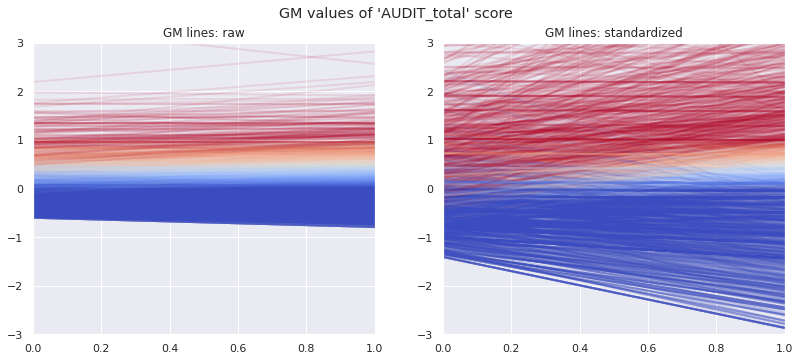

In [174]:
# load raw files provided by Prof. Rapp and Mira
# df = pd.read_csv("/ritter/share/data/IMAGEN/IMAGEN_RAW/growthcurves/AUDIT_total.csv", delimiter="\t")
# standardizing the slope and intercept values
# df[["Slope_scaled", "Intercept_scaled"]] = scaler.fit_transform(df[["Slope", "Intercept"]].values)

# or load already processed files
df = pd.read_csv("/ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/growthcurves/AUDIT/IMGN_AUDITtotal_GM.csv") 

f, axes = plt.subplots(1, 2, figsize=(12,5))
plt.suptitle("GM values of 'AUDIT_total' score")
axes[0].set_title("GM lines: raw")
axes[1].set_title("GM lines: standardized")

for i, row in df.iterrows():
    # plot actual values as lines
    abline(axes[0], row["Slope"], row["Intercept"])
    # also plot scaled values
    abline(axes[1], row["Slope_scaled"], row["Intercept_scaled"])
    
plt.show()

KMeans clustering on the scaled GM values:

Code from https://realpython.com/k-means-clustering-python/

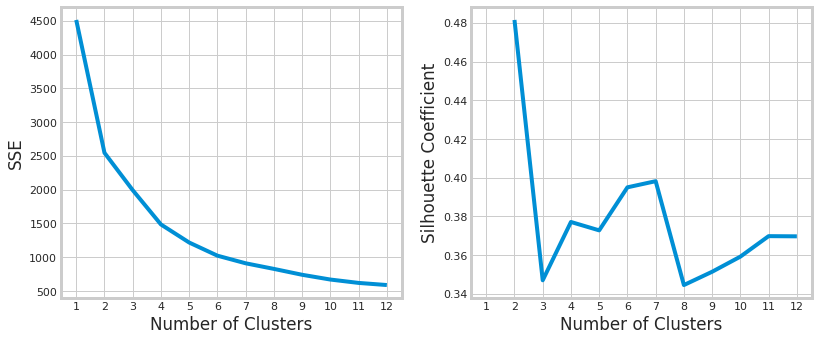

In [54]:
df = pd.read_csv(qs["AUDIT_GM"])
df[["Slope_scaled", "Intercept_scaled"]] = scaler.fit_transform(df[["Slope", "Intercept"]].values)
features = df[["Slope_scaled", "Intercept_scaled"]]

kmeans_kwargs = {"init":"random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": 42}
determine_clusters_k(features, kmeans_kwargs)

From the above graphs, seems like using 2 clusters would be the best choice 

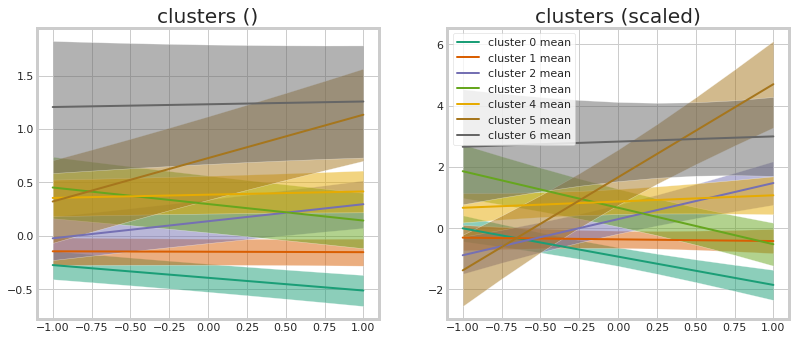

Per cluster count: 
0    507
1    887
2    287
3    130
4    274
5     87
6     85
Name: cluster, dtype: int64


In [57]:
kmeans = KMeans(n_clusters=7, **kmeans_kwargs)
kmeans.fit_transform(features)

df["cluster"] = kmeans.labels_
# reorder the clusters by their mean intercepts values
correct_cluster_order = df.groupby("cluster").mean().sort_values("Intercept").index
correct_cluster_dict = {c:i for i,c in enumerate(correct_cluster_order)}
df['cluster'] = df['cluster'].map(correct_cluster_dict)

viz_clusters(df)

In [58]:
# df = df.rename(columns={"﻿ID":"ID"}) # some descripency
# df.to_csv(AUDIT_GM_FINE, index=False) # AUDIT_GM_FINE, AUDIT_GM
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2257 entries, 0 to 2256
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BL_audit_total    2257 non-null   float64
 1   FU1_audit_total   2257 non-null   float64
 2   FU2_audit_total   2257 non-null   float64
 3   FU3_audit_total   2257 non-null   float64
 4   Intercept         2257 non-null   float64
 5   Slope             2257 non-null   float64
 6   ID                2257 non-null   float64
 7   Slope_scaled      2257 non-null   float64
 8   Intercept_scaled  2257 non-null   float64
 9   cluster           2257 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 176.5 KB


#### 2.5.2 GM ESPAD

##### 2.5.2.1 Compare the 3 questions roughly

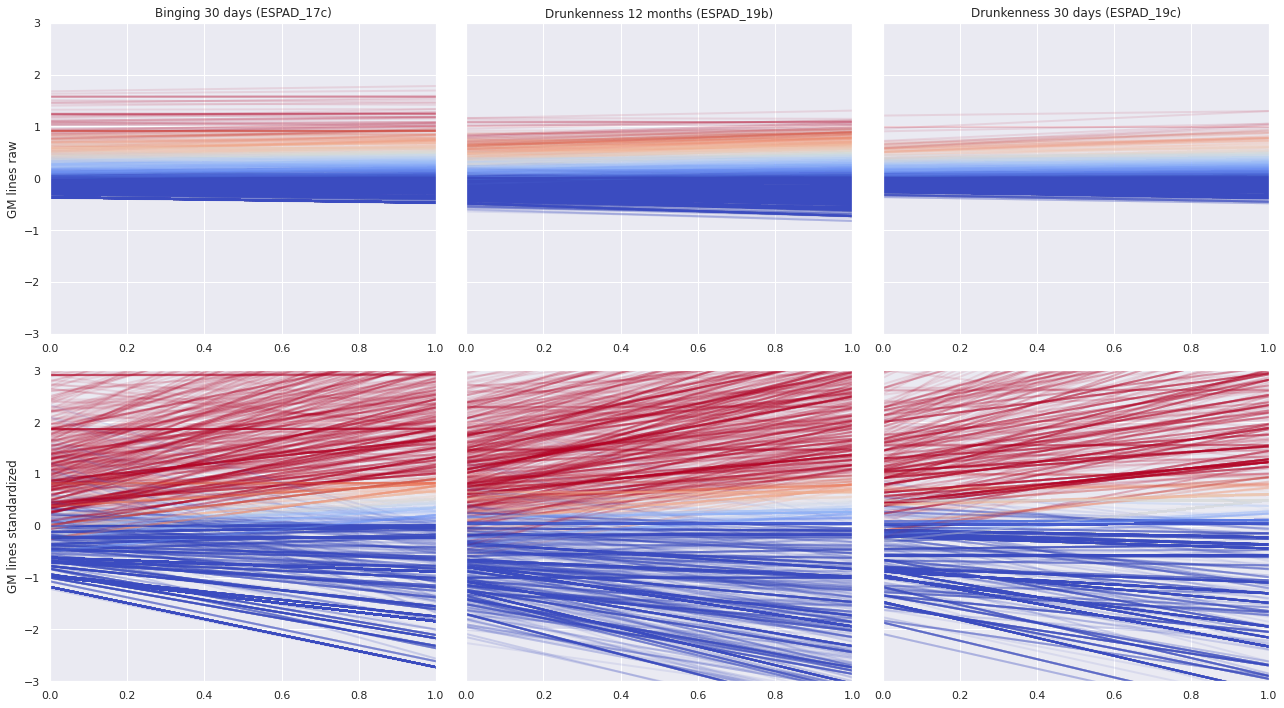

In [22]:
f, axes = plt.subplots(2, 3, figsize=(18,10), sharey=True)

axes[0][0].set_ylabel("GM lines raw")
axes[1][0].set_ylabel("GM lines standardized")

for i, (q, title) in enumerate([('ESPAD_17c', "Binging 30 days"), ('ESPAD_19b',"Drunkenness 12 months"), ('ESPAD_19c', "Drunkenness 30 days")]):
    
    df = pd.read_csv("/ritter/share/data/IMAGEN/IMAGEN_RAW/custom_labels/growthcurves/{}.csv".format(q), delimiter="\t")
    df[["Slope_scaled", "Intercept_scaled"]] = scaler.fit_transform(df[["Slope", "Intercept"]].values)
    
    for _, row in df.iterrows():
        abline(axes[0][i], row["Slope"], row["Intercept"])
        abline(axes[1][i], row["Slope_scaled"], row["Intercept_scaled"])
        
    axes[0][i].set_title("{} ({})".format(title, q))

plt.tight_layout()
plt.show()

##### 2.5.2.2 GM ESPAD 19b
Let's perform clustering on ESPAD 19b. <br>
Reason 1: The remaining 2 vars seem to have mostly flat lines and have short-term information (30 days). <br>
Reason 2: 19b is used in the paper https://pubmed.ncbi.nlm.nih.gov/31851304/ which can be used as baseline results for our analysis <br>

In [190]:
# Read in the data
BL = pd.read_csv(qs["ESPAD_BL"], sep=",", dtype={"User code":str, "Valid":str})
BL = BL.assign(time_point = "BL")
FU1 = pd.read_csv(qs["ESPAD_FU1"], sep=",", dtype={"User code":str, "Valid":str})
FU1 = FU1.assign(time_point = "FU1")
FU2 = pd.read_csv(qs["ESPAD_FU2"], sep=",", dtype={"User code":str, "Valid":str})
FU2 = FU2.assign(time_point = "FU2")
FU3 = pd.read_csv(qs["ESPAD_FU3"], sep=",", dtype={"User code":str, "Valid":str})
FU3 = FU3.assign(time_point = "FU3")


espad = pd.concat([BL, FU1, FU2, FU3])
espad["User code"] = espad["User code"].apply(lambda x: int(x.replace("-C", "")))
espad = espad.rename(columns={"User code" : "ID"})
del BL, FU1, FU2, FU3

#filter only the questions regarding alcohol since there are >1k columns
espad = espad[["ID", "time_point", 
               "8a", "8b", "8c", "9a", "9b", "9c", "9d", "17a", "17b", "17c",
               "29beer", "29wine", "29alcopop", "29spirits",
               "prev31", "19a", "19b", "19c", "29d", "20", "21"]]
# merge demographic data to this
espad = pd.merge(espad, df_demo, how="inner")

espad = espad.set_index(["time_point","ID"]).sort_index() #pd.MultiIndex.from_frame(df_audit[["ID", "time_point"]])

Total subjects initially in growthcurve csv = 1800
only 1329 subjects have data at atleast 2 time points. Dropping the rest as they are unreliable for modeling GM


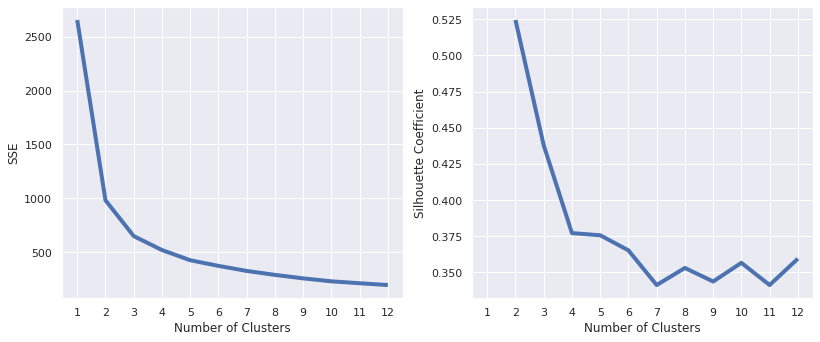

In [191]:
df = pd.read_csv("/ritter/share/data/IMAGEN/IMAGEN_RAW/custom_labels/growthcurves/ESPAD_19b.csv", delimiter="\t")
# only select the subjects that had atleast 2 data points for the growth curve estimation
df_temp = espad.reset_index()[["19b", "ID"]].dropna()
print("Total subjects initially in growthcurve csv = {}".format(len(df_temp["ID"].unique())))
sub_cnts = df_temp.ID.value_counts()
valid_subs = sub_cnts[sub_cnts>1].index
df = df[df['﻿ID'].isin(valid_subs)]
print("only {} subjects have data at atleast 2 time points. Dropping the rest as they are unreliable for modeling GM".format(len(df)))

df[["Slope_scaled", "Intercept_scaled"]] = scaler.fit_transform(df[["Slope", "Intercept"]].values)
features = df[["Slope_scaled", "Intercept_scaled"]] 

kmeans_kwargs = {"init":"random",
                 "n_init": 12,
                 "max_iter": 300,
                 "random_state": 42}
determine_clusters_k(features, kmeans_kwargs)

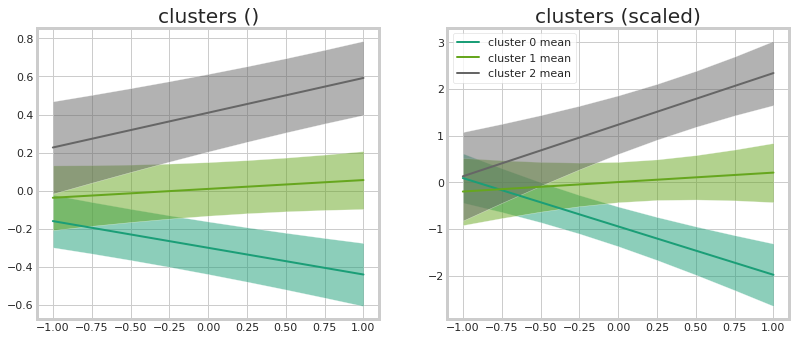

Per cluster count: 
0    490
1    465
2    374
Name: cluster, dtype: int64


In [196]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit_transform(features)

df["cluster"] = kmeans.labels_
# reorder the clusters by their mean intercepts values
correct_cluster_order = df.groupby("cluster").mean().sort_values("Intercept").index
correct_cluster_dict = {c:i for i,c in enumerate(correct_cluster_order)}
df['cluster'] = df['cluster'].map(correct_cluster_dict)

viz_clusters(df)

In [193]:
# # Save the new cluster groups
df = df.rename(columns={"﻿ID":"ID"}) # some descripency
df.to_csv(qs["ESPAD_GM"], index=False) # ESPAD_GM, ESPAD_GM_FINE, ESPAD_GM_SLP, ESPAD_GM_INT
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329 entries, 5 to 2256
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BL_ESP_19b        1329 non-null   float64
 1   FU1_ESP_19b       1329 non-null   float64
 2   FU2_ESP_19b       1329 non-null   float64
 3   FU3_ESP_19b       1329 non-null   float64
 4   Intercept         1329 non-null   float64
 5   Slope             1329 non-null   float64
 6   ID                1329 non-null   float64
 7   Slope_scaled      1329 non-null   float64
 8   Intercept_scaled  1329 non-null   float64
 9   cluster           1329 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 114.2 KB


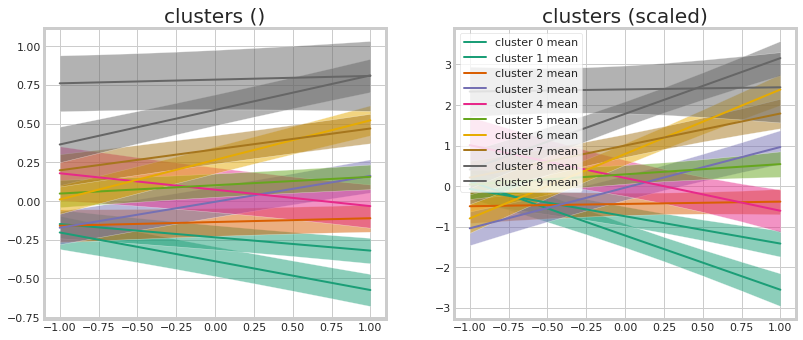

Per cluster count: 
0    241
1    233
2    133
3    101
4     87
5    165
6     98
7    148
8     91
9     32
Name: cluster, dtype: int64


In [201]:
kmeans = KMeans(n_clusters=10, **kmeans_kwargs)
kmeans.fit_transform(features)

df["cluster"] = kmeans.labels_
# reorder the clusters by their mean intercepts values
correct_cluster_order = df.groupby("cluster").mean().sort_values("Intercept").index
correct_cluster_dict = {c:i for i,c in enumerate(correct_cluster_order)}
df['cluster'] = df['cluster'].map(correct_cluster_dict)

viz_clusters(df)

In [202]:
# # Save the new cluster groups
df = df.rename(columns={"﻿ID":"ID"}) # some descripency
df.to_csv(qs["ESPAD_GM_FINE"], index=False) # ESPAD_GM, ESPAD_GM_FINE, ESPAD_GM_SLP, ESPAD_GM_INT
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329 entries, 5 to 2256
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BL_ESP_19b        1329 non-null   float64
 1   FU1_ESP_19b       1329 non-null   float64
 2   FU2_ESP_19b       1329 non-null   float64
 3   FU3_ESP_19b       1329 non-null   float64
 4   Intercept         1329 non-null   float64
 5   Slope             1329 non-null   float64
 6   ID                1329 non-null   float64
 7   Slope_scaled      1329 non-null   float64
 8   Intercept_scaled  1329 non-null   float64
 9   cluster           1329 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 114.2 KB


#### 2.5.3 GM TLFB

1. TLFB_alcohol1: 'Total # of days using alcohol in the past 30 days'
2. TLFB_alcohol2: 'Total # of Alcohol Drink Units in past 30 days'
3. TLFB_alcohol3: 'Total # of days using = 5 (for boys)/ = 4 (for girls) Alcohol Drink Units inpast 30 days'

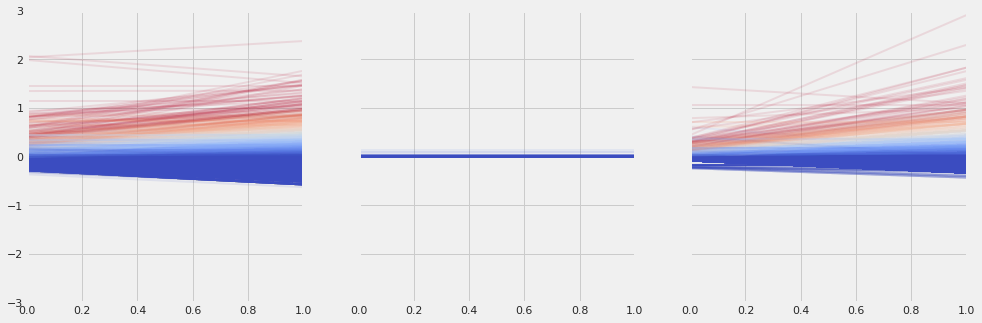

In [27]:
f, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)

df = pd.read_csv("/ritter/share/data/IMAGEN/IMAGEN_RAW/growthcurves/TLFB_alcohol1.csv", delimiter="\t")
for i, row in df.iterrows():
    abline(axes[0], row["Slope"], row["Intercept"])
    
df = pd.read_csv("/ritter/share/data/IMAGEN/IMAGEN_RAW/growthcurves/TLFB_alcohol2.csv", delimiter="\t")
for i, row in df.iterrows():
    abline(axes[1], row["Slope"], row["Intercept"])
    
df = pd.read_csv("/ritter/share/data/IMAGEN/IMAGEN_RAW/growthcurves/TLFB_alcohol3.csv", delimiter="\t")
for i, row in df.iterrows():
    abline(axes[2], row["Slope"], row["Intercept"])

plt.show()

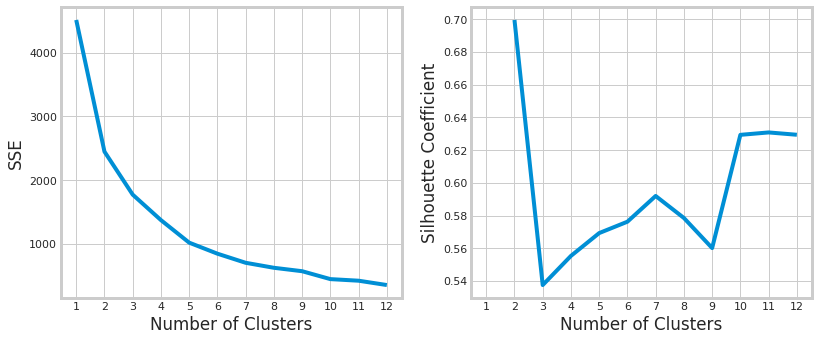

In [30]:
df = pd.read_csv("/ritter/share/data/IMAGEN/IMAGEN_RAW/growthcurves/TLFB_alcohol3.csv", delimiter="\t")
df[["Slope_scaled", "Intercept_scaled"]] = scaler.fit_transform(df[["Slope", "Intercept"]].values)
scaled_features = df[["Slope_scaled", "Intercept_scaled"]] 

kmeans_kwargs = {"init":"random",
                 "n_init": 12,
                 "max_iter": 300,
                 "random_state": 42}
determine_clusters_k(scaled_features, kmeans_kwargs)

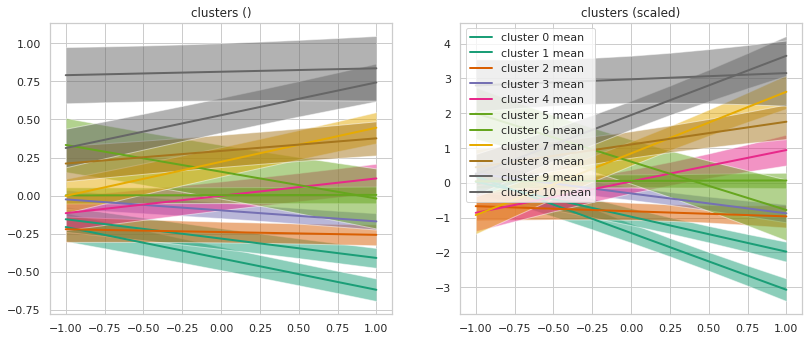

Per cluster count: 
0     208
1     308
2     170
3     136
4     173
5     726
6      34
7     149
8     167
9     149
10     37
Name: cluster, dtype: int64


In [16]:
kmeans = KMeans(n_clusters=11, **kmeans_kwargs)
kmeans.fit_transform(scaled_features)

df["cluster"] = kmeans.labels_
# reorder the clusters by their mean intercepts values
correct_cluster_order = df.groupby("cluster").mean().sort_values("Intercept").index
correct_cluster_dict = {c:i for i,c in enumerate(correct_cluster_order)}
df['cluster'] = df['cluster'].map(correct_cluster_dict)

viz_clusters(df)

In [132]:
# df = pd.concat([pd.read_csv(csv) for csv in glob("results/fsstats-all-*-gm*/*/run*.csv")], ignore_index=True)
# df = df.loc[:, ~df.columns.str.contains('^Unnamed')] # drop unnamed columns            
# df = df.sort_values(["io","technique", "model", "trial"]) # sort
# ! rm -rf results/fsstats-all*-gm-*
# os.makedirs("results/fsstats-all-gm-combinations/20210420-1220", exist_ok=True)
# df.to_csv("results/fsstats-all-gm-combinations/20210420-1220/run.csv", index=False)

## 2.5 Custom combinations

### 2.5.1 Seo et al

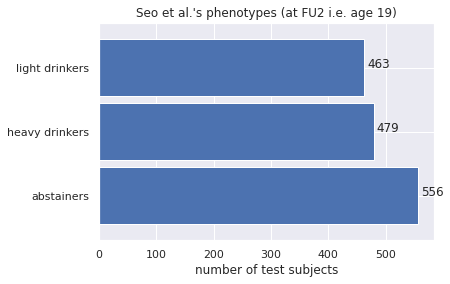

In [8]:
df = pd.read_csv(qs["PHENOTYPE"])
df.loc[:,"Phenotype"] = df["Phenotype"].map({0:"abstainers", 1:"light drinkers", 2:"heavy drinkers"})
plotGraph(df, "Phenotype", "barh", title="Seo et al.'s phenotypes (at FU2 i.e. age 19)")

### 2.5.2 Our custom combo

In [45]:
df_demo = pd.read_csv(join(DATA_DIR, "FU3/participants/IMAGEN_demographics.csv"), dtype={"PSC2":int})
df_demo = df_demo.rename(columns={"PSC2" : "ID", "recruitment centre":"site"})
df_demo2 = pd.read_csv(join(DATA_DIR, "IMAGEN_stats_from_db.csv"), sep=";", dtype={"code_in_study":int})
df_demo2 = df_demo2.rename(columns={"code_in_study" : "ID"})[["ID", "gender", "handedness"]]
df_demo = pd.merge(df_demo, df_demo2, on='ID', how="inner")

test_ids = df_demo.loc[df_demo["site"]=="NOTTINGHAM", "ID"]

print("Total subjects in demographics table =", len(df_demo))
print("Total subjects set aside as test set =", len(test_ids))
del df_demo2

BL = pd.read_csv(qs["AUDIT_BL"], dtype={"User code":str})
BL = BL.assign(time_point = "BL")
FU1 = pd.read_csv(qs["AUDIT_FU1"], dtype={"User code":str})
FU1 = FU1.assign(time_point = "FU1")
FU2 = pd.read_csv(qs["AUDIT_FU2"], dtype={"User code":str})
FU2 = FU2.assign(time_point = "FU2")
FU3 = pd.read_csv(qs["AUDIT_FU3"], dtype={"User code":str})
FU3 = FU3.assign(time_point = "FU3")

# merge all timepoints to a hierarchical table
df_audit = pd.concat([BL, FU1, FU2, FU3])
df_audit["User code"] = df_audit["User code"].apply(lambda x: int(x.replace("-C", "")))
df_audit = df_audit.rename(columns={"User code" : "ID"})

del BL, FU1, FU2, FU3
# merge demographic data to this
df_audit = pd.merge(df_audit, df_demo, how="inner")

# separate test subjects
df_audit_test = df_audit[df_audit["ID"].isin(test_ids)]
df_audit = df_audit[~df_audit["ID"].isin(test_ids)]

df_audit = df_audit.set_index(["time_point", "ID"]).sort_index() 
df_audit_test = df_audit_test.set_index(["time_point", "ID"]).sort_index() 
print(f"Generated AUDIT table of len {len(df_audit)} and a separate table with test subjects of len {len(df_audit_test)}")

# Read in the data
BL = pd.read_csv(qs["ESPAD_BL"], sep=",", dtype={"User code":str, "Valid":str})
BL = BL.assign(time_point = "BL")
FU1 = pd.read_csv(qs["ESPAD_FU1"], sep=",", dtype={"User code":str, "Valid":str})
FU1 = FU1.assign(time_point = "FU1")
FU2 = pd.read_csv(qs["ESPAD_FU2"], sep=",", dtype={"User code":str, "Valid":str})
FU2 = FU2.assign(time_point = "FU2")
FU3 = pd.read_csv(qs["ESPAD_FU3"], sep=",", dtype={"User code":str, "Valid":str})
FU3 = FU3.assign(time_point = "FU3")


espad = pd.concat([BL, FU1, FU2, FU3])
espad["User code"] = espad["User code"].apply(lambda x: int(x.replace("-C", "")))
espad = espad.rename(columns={"User code" : "ID"})
del BL, FU1, FU2, FU3

#filter only the questions regarding alcohol since there are >1k columns
espad = espad[["ID", "time_point", 
               "8a", "8b", "8c", "9a", "9b", "9c", "9d", "17a", "17b", "17c",
               "29beer", "29wine", "29alcopop", "29spirits",
               "prev31", "19a", "19b", "19c", "29d", "20", "21"]]
# merge demographic data to this
espad = pd.merge(espad, df_demo, how="inner")

# drop test subjects from analysis to avoid analysis bias
espad_test = espad[espad["ID"].isin(test_ids)]
espad = espad[~espad["ID"].isin(test_ids)]
espad = espad.set_index(["time_point","ID"]).sort_index() #pd.MultiIndex.from_frame(df_audit[["ID", "time_point"]])
espad_test = espad_test.set_index(["time_point","ID"]).sort_index()
print(f"Generated ESPAD table of len {len(espad)} and a separate table with test subjects of len  {len(espad_test)}")

Total subjects in demographics table = 2315
Total subjects set aside as test set = 375
Generated AUDIT table of len 5712 and a separate table with test subjects of len 1073


/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (105,125,140,166,168,170,185,236,244) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (84,140,158,174,190,191,195,218,220,221,287,298) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/ritter/roshan/installations/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (104,107,183,184,194,269,274,360,363,370,372,443,450,520,530,904,907) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Generated ESPAD table of len 5700 and a separate table with test subjects of len  1071


In [47]:
df_subset = df_demo.set_index("ID").drop(columns=["gender"])
df_subset["Binge_GM_slp"] = pd.read_csv(qs["ESPAD_GM_FINE"]).set_index("ID")["Slope"]
# df_subset["AUDIT_GM_slp"] = pd.read_csv(qs["AUDIT_GM_FINE"]).set_index("ID")["Slope"]

df_subset["Binge_lt"] = espad.loc["FU3"]["19a"] #+ espad.loc["FU2"]["19a"]
# df_subset["Binge_22yr"] = espad.loc["FU3"]["19b"]

df_subset["AUDIT_q1"] = df_audit.loc["FU3"]["audit1"]
df_subset["AUDIT_q2"] = df_audit.loc["FU3"]["audit2"]
# df_subset["AUDIT_GM_int"] = pd.read_csv(qs["AUDIT_GM_FINE"]).set_index("ID")["Intercept"]
# df_subset["Binge_GM_int"] = pd.read_csv(qs["ESPAD_GM_FINE"]).set_index("ID")["Intercept"]

features = [c for c in df_subset.columns if c not in ["sex", "site", "handedness"]]
print("features combined:\n", features)

features combined:
 ['Binge_GM_slp', 'Binge_lt', 'AUDIT_q1', 'AUDIT_q2']


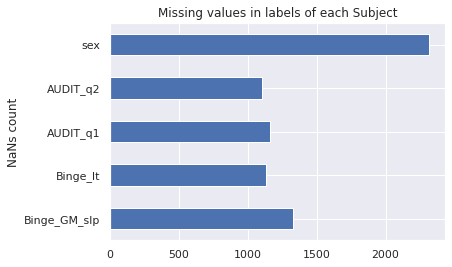

In [48]:
total = len(df_subset)
df_subset.notna().sum(axis=0)[features+["sex"]].plot.barh(ylabel="NaNs count",
                                                 title="Missing values in labels of each Subject")
plt.show()

In [49]:
# drop subjects that dont have atleast 60% of the metrics (the rest can be imputed)
nan_vals = (df_subset.isna().sum(axis=1))
df_subset = df_subset.loc[nan_vals < (0.5*len(features))]
print(f"Subset of subjects having atleast 50% of the metrics = {len(df_subset)}")
df_subset.info()

Subset of subjects having atleast 50% of the metrics = 1125
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1125 entries, 112288 to 99954902
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex           1125 non-null   object 
 1   site          1125 non-null   object 
 2   handedness    1125 non-null   object 
 3   Binge_GM_slp  913 non-null    float64
 4   Binge_lt      1122 non-null   float64
 5   AUDIT_q1      1125 non-null   float64
 6   AUDIT_q2      1101 non-null   float64
dtypes: float64(4), object(3)
memory usage: 70.3+ KB


In [50]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

In [51]:
df_subset_preproc = df_subset.copy()
# scale all features
df_subset_preproc[features] = scaler.fit_transform(df_subset_preproc[features].values)
# impute missing values
if df_subset_preproc.isna().any().any():
    df_subset_preproc[features] = imp.fit_transform(df_subset_preproc[features].values)
X = df_subset_preproc[features].values

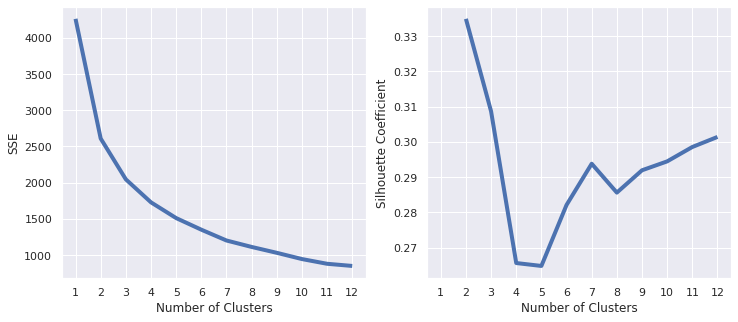

In [52]:
determine_clusters_k(X)

(<AxesSubplot:>,
 0    486
 1    431
 2    208
 Name: cluster, dtype: int64)

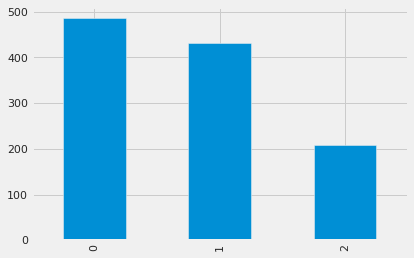

In [53]:
n = 3
kmeans = KMeans(n_clusters=n)
kmeans.fit_transform(df_subset_preproc[features].values)
df_subset_preproc["cluster"] = kmeans.labels_
# reorder the clusters by increasing order of alcohol misuse
correct_cluster_order = df_subset_preproc.groupby(
    "cluster").mean().sort_values("Binge_lt").index
correct_cluster_dict = {c:i for i,c in enumerate(correct_cluster_order)}
df_subset_preproc['cluster'] = df_subset_preproc['cluster'].map(correct_cluster_dict)
# gm = GaussianMixture(n_components=n, random_state=0).fit(X)
# df_subset_preproc["cluster"] = gm.predict(X)
df_subset_preproc["cluster"].value_counts().sort_index().plot.bar(), df_subset_preproc["cluster"].value_counts().sort_index()

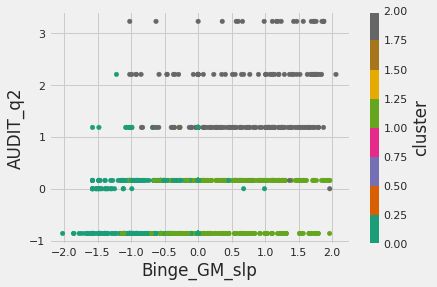

In [54]:
# reduce the features to 2 dimensions for visualization and plot them
from sklearn.decomposition import PCA

dims = features
# if X.shape[-1] > 2:
#     pca = PCA(n_components=2)
#     dims = ["pc0", "pc1"]
#     df_subset_preproc[dims] = pca.fit_transform(X)
df_subset_preproc.plot.scatter(x=dims[0], y=dims[-1], c="cluster", cmap="Dark2")
plt.show()

In [55]:
# apply to test subjects
df_subset_test = df_demo[df_demo["site"]=="NOTTINGHAM"].set_index("ID").drop(columns=["gender"])
df_subset_test["Binge_GM_slp"] = pd.read_csv(qs["ESPAD_GM_FINE"]).set_index("ID")["Slope"]
# df_subset["AUDIT_GM_slp"] = pd.read_csv(qs["AUDIT_GM_FINE"]).set_index("ID")["Slope"]

df_subset_test["Binge_lt"] = espad_test.loc["FU3"]["19a"] #+ espad.loc["FU2"]["19a"]
# df_subset["Binge_22yr"] = espad.loc["FU3"]["19b"]

df_subset_test["AUDIT_q1"] = df_audit_test.loc["FU3"]["audit1"]
df_subset_test["AUDIT_q2"] = df_audit_test.loc["FU3"]["audit2"]
# df_subset["AUDIT_GM_int"] = pd.read_csv(qs["AUDIT_GM_FINE"]).set_index("ID")["Intercept"]
# df_subset_test["Binge_GM_int"] = pd.read_csv(qs["ESPAD_GM_FINE"]).set_index("ID")["Intercept"]

features_test = [c for c in df_subset_test.columns if c not in ["sex", "site", "handedness"]]
print("features combined:\n", features_test)

features combined:
 ['Binge_GM_slp', 'Binge_lt', 'AUDIT_q1', 'AUDIT_q2']


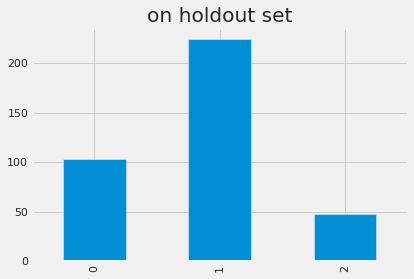

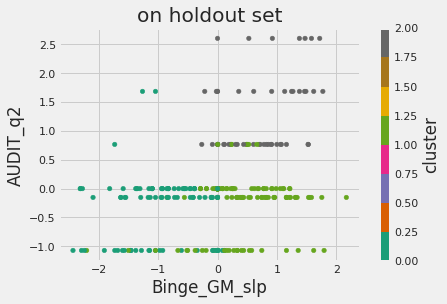

In [56]:
df_subset_preproc_test = df_subset_test.copy()
# scale all features
df_subset_preproc_test[features] = scaler.fit_transform(df_subset_preproc_test[features].values)
# impute missing values
if df_subset_preproc_test.isna().any().any():
    df_subset_preproc_test[features] = imp.fit_transform(df_subset_preproc_test[features].values)
X = df_subset_preproc_test[features].values
# determine the new clusters 
df_subset_preproc_test["cluster"] = kmeans.predict(df_subset_preproc_test[features].values)

df_subset_preproc_test['cluster'] = df_subset_preproc_test['cluster'].map(correct_cluster_dict)
df_subset_preproc_test["cluster"].value_counts().sort_index().plot.bar(title="on holdout set")
plt.show()
dims = features
df_subset_preproc_test.plot.scatter(x=dims[0], y=dims[-1], c="cluster", cmap="Dark2", title="on holdout set")
plt.show()

In [57]:
df_subset_preproc = pd.concat([df_subset_preproc, df_subset_preproc_test])
print("final length of labels file", print(len(df_subset_preproc)))

1500
final length of labels file None


In [58]:
df_subset_preproc.to_csv(DATA_DIR+"/combinations/our_custom_combo/our_custom_combo.csv")

In [66]:
from imagen_dataloader import Imagen
d = Imagen()

d.load_label(df_subset_preproc.reset_index(), col='cluster', viz=False, binarize=True, class0=0, class1=1, y_colname='combo')
d.prepare_X("BL", viz=False)
d.hdf5_name_x = "combo-combos"
for feature in features:
    d.hdf5_name_y += "-" + feature
d.save_h5()

Final dataframe prepared. 
Total subjects = 1958
saving h5 file at /ritter/share/data/IMAGEN/h5files/combo-combos-combol0u1-binge-gm-slp-binge-lt-audit-q1-audit-q-n1958.h5


OSError: [Errno 37] Unable to create file (unable to lock file, errno = 37, error message = 'No locks available')

In [67]:
print_h5list("combo-combos-")

 ('/ritter/share/data/IMAGEN/h5files/combo-combos-combol0u1-binge-gm-slp-binge-lt-audit-q1-audit-q-n1035.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/combo-combos-combol0u1-binge-gm-slp-binge-lt-audit-q1-audit-q-n1276.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/combo-combos-combol0u1-binge-gm-slp-binge-lt-audit-q1-audit-q-n1958.h5', 'all'),


# 3. Personality & Family History
(todo)

1. LEQ: Negative life events
2. SURPS:
    1. Impulsivity
    2. Sensation
    3. Anxiety sensitivity 
    4. Negative thinking
3. NEO PI:
    1. Neuroticism
    2. Extraversion
    3. Openness
    4. Agreeableness
    5. Conscientiousness

# 4. Final candidates for ML experiment

1. Binge drinking:
    1. ESPAD 19: drunkenness experiences in lifetime (19a) or last 12 months (19b) or last 30 days (19c) 
    2. ESPAD 17: binge drinking experiences (>5  drinks  during  one occassion) in lifetime (17a) or last 12 months (17b) or last 30 days (17c)
    3. AUDIT q3: "How often do you have 5 or more drinks on one occasion?"
2. Amount of alcohol consumed recently (last month): 
    1. ESPAD 8c: amount of alcohol consumed in last 30 days
    2. TLFB_alcohol2: amount of alcohol consumed in last 30 days
    3. ESPAD 8a = 0 and AUDIT total = 0: Subjects who never consumed any alcohol or tobacco by age 14 (BL) and 16 (FU1)
3. Number of Occasions:
4. Onset of heavy drinking:
    1. ESPAD 29d: When did you first get drunk from drinking alcoholic beverages?
5. AUDIT:
    * AUDIT_q1to3: measures frequency of alcohol use and alcohol misuse in the last 12 months
    
Some interesting findings:
1. Trends for AUDIT and ESPAD questions show that drinking habits 
    1. change drastically from age 14 (BL) to age 16 (FU1) 
    2. changes moderately from age 16 (FU1) to age 19 (FU2)
    3. and then changes slightly from age 19 (FU2) to age 22 (FU3)
2. Subjects who did not have any alcohol (~200) by FU2 can be used as a sanity check against confounds for our ML experiments. The ML model should atleast predict low probability for them.
3. 'first time drank xxx alcohol' questions i.e. ESPAD29x are not very reliable as proven in  2.2.4. Better to use range of values to reduce this noise. 
4. Questions measuring 'lifetime' habits like ESPAD 19a,17a,8a etc. are not very reliable. 

In [27]:
from imagen_dataloader import *

In [28]:
d = Imagen()
valid_ids = set(d.df.index) | set(d.df_holdout.index)
for f in sorted(glob(BIDS_DIR+"sMRI-derivatives_*.csv")):
    df = pd.read_csv(f)
    df_dropped = df.dropna()
    print(f.split("/")[-1].replace(".csv", "").replace("sMRI-derivatives_",""), len(df), len(df_dropped))
    valid_ids &= set(df_dropped["ID"])
print("subset of subjects who appeared at all 3 time points:", len(valid_ids))

BL 2106 1691
FU2 1423 1341
FU3 1182 1113
subset of subjects who appeared at all 3 time points: 737


## 4.1 Investigate different boundaries: GM

In [30]:
lbl_combinations = [  
    ("AUDIT_GM"     , "cluster", 0, 3, 'AUDIT_GM(0|3)'),
    ("AUDIT_GM"     , "cluster", 1, 3, 'AUDIT_GM(1|3)'),
    ("AUDIT_GM"     , "cluster", 1, 2, 'AUDIT_GM(1|2)'),
    
    ("AUDIT_GM_FINE", "cluster", [0,3], [2,5], 'AUDIT_GM_FINE_SLP'),
    ("AUDIT_GM_FINE", "cluster", 1, 3, 'AUDIT_GM_FINE_INT'),
    ("AUDIT_GM_FINE", "cluster", 1, 5, 'AUDIT_GM_FINE(1|5)'),
    ("AUDIT_GM_FINE", "cluster", 2, 4, 'AUDIT_GM_FINE(2|4)'),    
    
    ("ESPAD_GM"     , "cluster", 0, 2, 'BINGE_GM(0|2)'),
    ("ESPAD_GM"     , "cluster", 1, 2, 'BINGE_GM(1|2)'),
    ("ESPAD_GM"     , "cluster", 0, 1, 'BINGE_GM(0|1)'),
    
    ("ESPAD_GM_FINE", "cluster", 3,       [5,6,7,8], 'BINGE_GM_FINE_SLP'),
    ("ESPAD_GM_FINE", "cluster", [0,1,3], [5,7,8]  , 'BINGE_GM_FINE_SLP_EXT'),
    ("ESPAD_GM_FINE", "cluster", [0,1,2,5], [6,8,9], 'BINGE_GM_FINE_INT'),
    ("ESPAD_GM_FINE", "cluster", 2, 6, 'BINGE_GM_FINE(2|6)'),
    ("ESPAD_GM_FINE", "cluster", 3, 6, 'BINGE_GM_FINE(3|6)'),
    ("ESPAD_GM_FINE", "cluster", 2, [5,7,8,9], 'BINGE_GM_FINE(2|5(no6)))')
]
name="gm-combos"
create_h5s(lbl_combinations, name, viz=0)

Final dataframe prepared. 
Total subjects = 490
saving h5 file at /ritter/share/data/IMAGEN/h5files/gm-combos-audit-gm-cluster-audit-gm-0-3-n490.h5
Final dataframe prepared. 
Total subjects = 840
saving h5 file at /ritter/share/data/IMAGEN/h5files/gm-combos-audit-gm-cluster-audit-gm-1-3-n840.h5
Final dataframe prepared. 
Total subjects = 966
saving h5 file at /ritter/share/data/IMAGEN/h5files/gm-combos-audit-gm-cluster-audit-gm-1-2-n966.h5
Final dataframe prepared. 
Total subjects = 569
saving h5 file at /ritter/share/data/IMAGEN/h5files/gm-combos-audit-gm-fine-cluster-audit-gm-fine-slp-n569.h5
Final dataframe prepared. 
Total subjects = 803
saving h5 file at /ritter/share/data/IMAGEN/h5files/gm-combos-audit-gm-fine-cluster-audit-gm-fine-int-n803.h5
Final dataframe prepared. 
Total subjects = 639
saving h5 file at /ritter/share/data/IMAGEN/h5files/gm-combos-audit-gm-fine-cluster-audit-gm-fine-1-5-n639.h5
Final dataframe prepared. 
Total subjects = 894
saving h5 file at /ritter/share/da

In [12]:
! ls /ritter/share/data/IMAGEN/IMAGEN_RAW/2.7/growthcurves/AUDIT/

IMGN_AUDITtotal_GM.csv	IMGN_AUDITtotal_GM_FINE.csv  IMGN_ESPAD19b_GM.csv


In [11]:
print_h5list(name)

 ('/ritter/share/data/IMAGEN/h5files/gm-combos-audit-gm-fine-cluster-audit-gm-fine-slp-n598.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/gm-combos-espad-gm-cluster-binge-gm-0-2-n628.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/gm-combos-espad-gm-fine-cluster-binge-gm-fine-2-6-n668.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/gm-combos-espad-gm-fine-cluster-binge-gm-fine-slp-n818.h5', 'all'),


## 4.2 Investigate different boundaries: Binge and Onset

Safe users           308
Moderate misusers    511
Heavy misusers       216
Name: BINGE_onset(14|17), dtype: int64
Final dataframe prepared. 
Total subjects = 1035
Distributions in final dataframe:


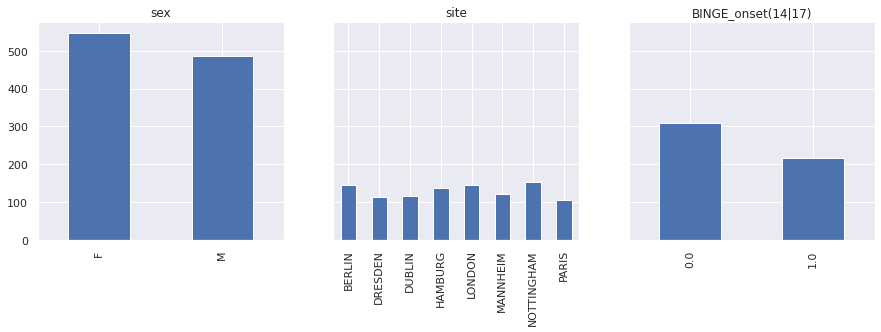

Total subjects = 1035
shape of X (1035, 722)


In [40]:
lbl_combinations = [  
#     ("ESPAD_BL",  '19a', 1, 3,   'BINGE_14yr(1|3)'),
    
#     ("ESPAD_FU1", '19a', 1, 4,   'BINGE_16yr(1|4)'),
#     ("ESPAD_FU1", '19a', 2, 4,   'BINGE_16yr(2|4)'),
    
#     ("ESPAD_FU2", '19a', 1, 4,   'BINGE_19yr(1|4)'),
#     ("ESPAD_FU2", '19a', 2, 5,   'BINGE_19yr(2|5)'),
#     ("ESPAD_FU2", '19a', 3, 6,   'BINGE_19yr(3|6)'),

#     ("ESPAD_FU3", '19a', 1, 4,   'BINGE_22yr(1|4)'),
#     ("ESPAD_FU3", '19a', 2, 5,   'BINGE_22yr(2|5)'),
#     ("ESPAD_FU3", '19a', 3, 6,   'BINGE_22yr(3|6)'),
    
#     ("ESPAD_BL",  '19a', 0, 1,   'BINGE_14yr_onset'),
#     ("ESPAD_BL",  '19a', 0, 2,   'BINGE_14yr_onset(0|2)'),
#     ("ESPAD_BL",  '19a', 0, 3,   'BINGE_14yr_onset(0|3)'),
#     ("ESPAD_FU1", '19a', 0, 1,   'BINGE_16yr_onset'),
#     ("ESPAD_FU1", '19a', 0, 4,   'BINGE_16yr_onset(0|4)'),
#     ("ESPAD_FU2", '19a', 0, 1,   'BINGE_19yr_onset'),
#     ("ESPAD_FU2", '19a', 0, 4,   'BINGE_19yr_onset(0|4)'),
#     ("ESPAD_FU3", '19a', 0, 1,   'BINGE_22yr_onset'),

#     ("ESPAD_FU3", '29d', [16,17,18,19,20,21], [11,12,13,14],   'BINGE_onset(14|16)'),
#     ("ESPAD_FU3", '29d', 16, [18,19,20,21],   'BINGE_onset(16|18)'),
    
    
#     ("ESPAD_FU2", '19b', 2, 4,   'BINGEyr_19yr(2|4)'),

#     ("ESPAD_FU3", '19b', 2, 4,   'BINGEyr_22yr(2|4)'),
#     ("ESPAD_FU3", '19b', 2, 5,   'BINGEyr_22yr(2|5)'),
    
#     ("ESPAD_FU3", '19c', 0, 1,   'BINGEmnt_22yr(0|1)'),
#     ("ESPAD_FU3", '19c', 1, 2,   'BINGEmnt_22yr(1|2)'),
]
name="binge-combos"
create_h5s(lbl_combinations, name, viz=1)

## 4.3 Investigate different boundaries: Freq and Amount

In [57]:
lbl_combinations = [  
    ("ESPAD_BL",  '8c', 0, 1,   'FREQ_14yr(0|1)'),    
    ("ESPAD_FU1", '8c', 1, 3,   'FREQ_16yr(1|3)'),    
    ("ESPAD_FU2", '8c', 1, 3,   'FREQ_19yr(1|3)'),
    ("ESPAD_FU3", '8c', 2, 4,   'FREQ_22yr(2|4)'),  
    
    ("ESPAD_BL",  '8b', 1, 3,   'FREQyr_14yr(1|3)'),    
    ("ESPAD_FU1", '8b', 3, 5,   'FREQyr_16yr(3|5)'),    
    ("ESPAD_FU2", '8b', 4, 6,   'FREQyr_19yr(4|6)'),
    ("ESPAD_FU3", '8b', 4, 6,   'FREQyr_22yr(4|6)'),
]
name="freq-combos"
create_h5s(lbl_combinations, name, viz=0)

Final dataframe prepared. 
Total subjects = 621
saving h5 file at /ritter/share/data/IMAGEN/h5files/freq-combos-espad-bl-8c-freq-14yr-0-1-n621.h5
Final dataframe prepared. 
Total subjects = 587
saving h5 file at /ritter/share/data/IMAGEN/h5files/freq-combos-espad-fu1-8c-freq-16yr-1-3-n587.h5
Final dataframe prepared. 
Total subjects = 587
saving h5 file at /ritter/share/data/IMAGEN/h5files/freq-combos-espad-fu2-8c-freq-19yr-1-3-n587.h5
Final dataframe prepared. 
Total subjects = 713
saving h5 file at /ritter/share/data/IMAGEN/h5files/freq-combos-espad-fu3-8c-freq-22yr-2-4-n713.h5
Final dataframe prepared. 
Total subjects = 574
saving h5 file at /ritter/share/data/IMAGEN/h5files/freq-combos-espad-bl-8b-freqyr-14yr-1-3-n574.h5
Final dataframe prepared. 
Total subjects = 630
saving h5 file at /ritter/share/data/IMAGEN/h5files/freq-combos-espad-fu1-8b-freqyr-16yr-3-5-n630.h5
Final dataframe prepared. 
Total subjects = 627
saving h5 file at /ritter/share/data/IMAGEN/h5files/freq-combos-espa

In [71]:
lbl_combinations = [  
    ("ESPAD_BL",  'prev31', 0, 1,   'AMT_14yr(0|1)'),    
    ("ESPAD_FU1", 'prev31', 1, 3,   'AMT_16yr(1|3)'),    
    ("ESPAD_FU2", 'prev31', 1, 3,   'AMT_19yr(1|3)'),
    ("ESPAD_FU3", 'prev31', 2, 4,   'AMT_22yr(2|4)'),  
    
    ("AUDIT_BL",  'audit2', 0, 1,   'AMT_14yr_a(0|1)'),    
    ("AUDIT_FU1", 'audit2', 0, 2,   'AMT_16yr_a(0|2)'),    
    ("AUDIT_FU2", 'audit2', 0, 2,   'AMT_19yr_a(0|2)'),
    ("AUDIT_FU3", 'audit2', 0, 2,   'AMT_22yr_a(0|2)'),
]
name="amt-combos"
create_h5s(lbl_combinations, name, viz=0)

Final dataframe prepared. 
Total subjects = 724
saving h5 file at /ritter/share/data/IMAGEN/h5files/amt-combos-espad-bl-prev31-amt-14yr-0-1-n724.h5
Final dataframe prepared. 
Total subjects = 600
saving h5 file at /ritter/share/data/IMAGEN/h5files/amt-combos-espad-fu1-prev31-amt-16yr-1-3-n600.h5
Final dataframe prepared. 
Total subjects = 579
saving h5 file at /ritter/share/data/IMAGEN/h5files/amt-combos-espad-fu2-prev31-amt-19yr-1-3-n579.h5
Final dataframe prepared. 
Total subjects = 796
saving h5 file at /ritter/share/data/IMAGEN/h5files/amt-combos-espad-fu3-prev31-amt-22yr-2-4-n796.h5
Final dataframe prepared. 
Total subjects = 465
saving h5 file at /ritter/share/data/IMAGEN/h5files/amt-combos-audit-bl-audit2-amt-14yr-a-0-1-n465.h5
Final dataframe prepared. 
Total subjects = 471
saving h5 file at /ritter/share/data/IMAGEN/h5files/amt-combos-audit-fu1-audit2-amt-16yr-a-0-2-n471.h5
Final dataframe prepared. 
Total subjects = 511
saving h5 file at /ritter/share/data/IMAGEN/h5files/amt-

## 4.3 Investigate different boundaries: AUDIT

In [33]:
lbl_combinations = [  
    ("AUDIT_BL",   'audit_total', 3, 4,   'AUDIT_14yr(3|4)'),
    ("AUDIT_FU1",  'audit_total', 3, 4,   'AUDIT_16yr(3|4)'),
    ("AUDIT_FU2",  'audit_total', 3, 4,   'AUDIT_19yr(3|4)'),
    ("AUDIT_FU3",  'audit_total', 3, 4,   'AUDIT_22yr(3|4)'),
    
    ("AUDIT_BL",   'audit_total', 3, 5,   'AUDIT_14yr(3|5)'),
    ("AUDIT_FU1",  'audit_total', 3, 5,   'AUDIT_16yr(3|5)'),
    ("AUDIT_FU2",  'audit_total', 3, 5,   'AUDIT_19yr(3|5)'),
    ("AUDIT_FU3",  'audit_total', 3, 5,   'AUDIT_22yr(3|5)'),
    
    ("AUDIT_BL",   'audit_freq', 2, 4,   'AUDIT_C_14yr(2|4)'),
    ("AUDIT_FU1",  'audit_freq', 2, 4,   'AUDIT_C_16yr(2|4)'),
    ("AUDIT_FU2",  'audit_freq', 2, 4,   'AUDIT_C_19yr(2|4)'),
    ("AUDIT_FU3",  'audit_freq', 2, 4,   'AUDIT_C_22yr(2|4)'),
    
    ("AUDIT_BL",   'audit_freq', 1, 3,   'AUDIT_C_14yr(1|3)'),
    ("AUDIT_FU1",  'audit_freq', 1, 3,   'AUDIT_C_16yr(1|3)'),
    
    ("AUDIT_BL",   'audit_symp', 0, 1,   'AUDIT_D_14yr(0|2)'),
    ("AUDIT_FU1",  'audit_symp', 0, 1,   'AUDIT_D_16yr(0|2)'),
    ("AUDIT_FU2",  'audit_symp', 0, 2,   'AUDIT_D_19yr(0|2)'),
    ("AUDIT_FU3",  'audit_symp', 0, 2,   'AUDIT_D_22yr(0|2)'),
]
name="audit-combos"
create_h5s(lbl_combinations, name, viz=0)

Final dataframe prepared. 
Total subjects = 961
saving h5 file at /ritter/share/data/IMAGEN/h5files/audit-combos-audit-bl-audit-total-audit-14yr-3-4-n961.h5
Final dataframe prepared. 
Total subjects = 856
saving h5 file at /ritter/share/data/IMAGEN/h5files/audit-combos-audit-fu1-audit-total-audit-16yr-3-4-n856.h5
Final dataframe prepared. 
Total subjects = 855
saving h5 file at /ritter/share/data/IMAGEN/h5files/audit-combos-audit-fu2-audit-total-audit-19yr-3-4-n855.h5
Final dataframe prepared. 
Total subjects = 962
saving h5 file at /ritter/share/data/IMAGEN/h5files/audit-combos-audit-fu3-audit-total-audit-22yr-3-4-n962.h5
Final dataframe prepared. 
Total subjects = 928
saving h5 file at /ritter/share/data/IMAGEN/h5files/audit-combos-audit-bl-audit-total-audit-14yr-3-5-n928.h5
Final dataframe prepared. 
Total subjects = 774
saving h5 file at /ritter/share/data/IMAGEN/h5files/audit-combos-audit-fu1-audit-total-audit-16yr-3-5-n774.h5
Final dataframe prepared. 
Total subjects = 741
saving

In [82]:
print_h5list("*-combos")

 ('/ritter/share/data/IMAGEN/h5files/amt-combos-audit-bl-audit2-amt-14yr-a-0-1-n465.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/amt-combos-audit-fu1-audit2-amt-16yr-a-0-2-n471.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/amt-combos-audit-fu2-audit2-amt-19yr-a-0-2-n511.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/amt-combos-audit-fu3-audit2-amt-22yr-a-0-2-n585.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/amt-combos-espad-bl-prev31-amt-14yr-0-1-n724.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/amt-combos-espad-fu1-prev31-amt-16yr-1-3-n600.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/amt-combos-espad-fu2-prev31-amt-19yr-1-3-n579.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/amt-combos-espad-fu3-prev31-amt-22yr-2-4-n796.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/audit-combos-audit-bl-audit-freq-audit-c-14yr-1-3-n865.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/audit-combos-audit-bl-audit-freq-audit-c-14yr-2-4-n910.h5', 'all'),
 ('/ritter/share

## 4.3 Final set of labels

In [23]:
# for f in ["/ritter/share/data/IMAGEN/h5files/newlbls-fu3-audit-fu3-audit2-amount-n630.h5",
# "/ritter/share/data/IMAGEN/h5files/newlbls-fu3-espad-fu3-8b-frequency-n762.h5",
# "/ritter/share/data/IMAGEN/h5files/newlbls-bl-audit-fu3-audit2-amount-n728.h5",
# "/ritter/share/data/IMAGEN/h5files/newlbls-bl-espad-fu3-8b-frequency-n868.h5",
# "/ritter/share/data/IMAGEN/h5files/newlbls-bl-our-combo-cluster-combined-ours-n732.h5",
# "/ritter/share/data/IMAGEN/h5files/newlbls-fu2-audit-fu3-audit2-amount-n614.h5",
# "/ritter/share/data/IMAGEN/h5files/newlbls-fu2-espad-fu3-8b-frequency-n742.h5",
# "/ritter/share/data/IMAGEN/h5files/newlbls-fu2-our-combo-cluster-combined-ours-n625.h5",
# "/ritter/share/data/IMAGEN/h5files/newlbls-fu3-our-combo-cluster-combined-ours-n631.h5"]:
#     os.remove(f)
! ls -t /ritter/share/data/IMAGEN/h5files/newlbls-*binge-growth*

/ritter/share/data/IMAGEN/h5files/newlbls-bl-espad-gm-fine-cluster-binge-growth-n849.h5
/ritter/share/data/IMAGEN/h5files/newlbls-fu2-espad-gm-fine-cluster-binge-growth-n720.h5
/ritter/share/data/IMAGEN/h5files/newlbls-fu3-espad-gm-fine-cluster-binge-growth-n614.h5


In [22]:
tp = "BL"
modality = ""
name=f"newlbls{modality}-{tp.lower()}"

lbl_combinations = [  
#     ("ESPAD_FU3",        '19a',        3, 6,   'Binge'),
    ("ESPAD_GM_FINE",  'cluster',   2, 6,   'Binge_growth'),
#     ("PHENOTYPE",      'Phenotype', 0, 2,   'Combined_seo'),
#     ("OUR_COMBO",      'cluster', 0, 2,   'Combined_ours'),
#     (f"AUDIT_FU3",     'audit_total', 4, 8,   'AUDIT'),
#     (f"AUDIT_FU3",     'audit_freq', 3, 6,   'AUDIT_quick'),
#     ("AUDIT_GM_FINE",  "cluster", [0,3], [2,5,6], 'AUDIT_growth'),
#     ("ESPAD_FU3",      '29d', [16,17,18,19,20,21], [11,12,13,14],   'onset<15'),
#     ("ESPAD_FU3", '8b', 4, 6, 'Frequency'),
#     (f"AUDIT_FU3",   'audit2', 0, 2, 'Amount'),
]

create_h5s(lbl_combinations, name, x_tp=tp, use_all_data=False, viz=0, feature_cols=f"^T1w_.*{modality}.*")

Final dataframe prepared. 
Total subjects = 849
saving h5 file at /ritter/share/data/IMAGEN/h5files/newlbls-bl-espad-gm-fine-cluster-binge-growth-n849.h5


Also create the holdouts

In [30]:
name = f"newholdoutt1w-{tp.lower()}"
create_h5s(lbl_combinations, name, x_tp=tp, use_only_holdout=True, viz=0, feature_cols="T1w_.*")

Final dataframe prepared. 
Total subjects = 102
saving h5 file at /ritter/share/data/IMAGEN/h5files/newholdoutt1w-fu3-espad-fu3-19a-binge-n102.h5
Final dataframe prepared. 
Total subjects = 108
saving h5 file at /ritter/share/data/IMAGEN/h5files/newholdoutt1w-fu3-espad-gm-fine-cluster-binge-growth-n108.h5
Final dataframe prepared. 
Total subjects = 101
saving h5 file at /ritter/share/data/IMAGEN/h5files/newholdoutt1w-fu3-phenotype-phenotype-combined-seo-n101.h5
Final dataframe prepared. 
Total subjects = 116
saving h5 file at /ritter/share/data/IMAGEN/h5files/newholdoutt1w-fu3-our-combo-cluster-combined-ours-n116.h5
Final dataframe prepared. 
Total subjects = 102
saving h5 file at /ritter/share/data/IMAGEN/h5files/newholdoutt1w-fu3-audit-fu3-audit-total-audit-n102.h5
Final dataframe prepared. 
Total subjects = 99
saving h5 file at /ritter/share/data/IMAGEN/h5files/newholdoutt1w-fu3-audit-fu3-audit-freq-audit-quick-n99.h5
Final dataframe prepared. 
Total subjects = 89
saving h5 file at 

In [16]:
print_h5list("newlbls")#name.split("-")[0].lower())#

 ('/ritter/share/data/IMAGEN/h5files/newlbls-bl-audit-fu3-audit-freq-audit-quick-n614.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newlbls-bl-audit-fu3-audit-total-audit-n687.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newlbls-bl-audit-gm-fine-cluster-audit-growth-n759.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newlbls-bl-espad-fu3-19a-binge-n620.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newlbls-bl-espad-fu3-29d-onset-15-n654.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newlbls-bl-espad-fu3-8c-frequency-n660.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newlbls-bl-espad-fu3-prev31-amount-n620.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newlbls-bl-espad-gm-fine-cluster-binge-growth-n781.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newlbls-bl-our-combo-cluster-combined-ours-n793.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newlbls-bl-phenotype-phenotype-combined-seo-n740.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newlbls-fu2-audit

In [31]:
print_h5list("newholdoutdti")#

 ('/ritter/share/data/IMAGEN/h5files/newholdoutdti-bl-audit-fu3-audit-freq-audit-quick-n99.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newholdoutdti-bl-audit-fu3-audit-total-audit-n102.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newholdoutdti-bl-audit-gm-fine-cluster-audit-growth-n89.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newholdoutdti-bl-espad-fu3-19a-binge-n102.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newholdoutdti-bl-espad-fu3-29d-onset-15-n114.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newholdoutdti-bl-espad-fu3-8c-frequency-n118.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newholdoutdti-bl-espad-fu3-prev31-amount-n93.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newholdoutdti-bl-espad-gm-fine-cluster-binge-growth-n108.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newholdoutdti-bl-our-combo-cluster-combined-ours-n116.h5', 'all'),
 ('/ritter/share/data/IMAGEN/h5files/newholdoutdti-bl-phenotype-phenotype-combined-seo-n101.h5', 'all'

In [283]:
# from imagen_dataloader import Imagen
# VIZ = False
# d = Imagen()

In [67]:
# dfq = pd.read_csv(qs["AUDIT_GM_FINE"], usecols=["ID", "cluster"])
# d.load_label(dfq, col="cluster", viz=VIZ, binarize=True, class0=2, class1=4, y_colname='AUDIT_growth')
# dfq = pd.read_csv(qs["ESPAD_GM_FINE"], usecols=["ID", "cluster"])
# d.load_label(dfq, col="cluster", viz=VIZ, binarize=True, class0=2, class1=6, y_colname='Binge_growth').info()

In [68]:
# dfq = pd.read_csv(qs["PHENOTYPE"], usecols=["ID", "Phenotype"])
# d.load_label(dfq, col="Phenotype", viz=VIZ, binarize=True, class0=0, class1=2, y_colname='Seo_phenotype').info()

In [227]:
# dfq = pd.read_csv(DATA_DIR+"FU3/psytools/IMAGEN-IMGN_AUDIT_FU3.csv", 
#                   usecols=["User code", "audit_total"], dtype={"User code":str})
# dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
# dfq = dfq.drop("User code", axis=1)
            
# d.load_label(dfq, col="audit_total", viz=VIZ, binarize=True, class0=6, class1=7, y_colname='AUDIT_total').info()

In [228]:
# dfq = pd.read_csv("FU3/psytools/IMAGEN-IMGN_AUDIT_FU3.csv", 
#                   usecols=["User code", "audit_freq"], dtype={"User code":str})
# dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
# dfq = dfq.drop("User code", axis=1)
            
# d.load_label(dfq, col="audit_freq", viz=VIZ, binarize=True, class0=3, class1=4, y_colname='AUDIT_C').info()

In [229]:
# dfq = pd.read_csv(DATA_DIR+"BL/psytools/IMAGEN-IMGN_AUDIT_CHILD_RC5-IMAGEN_DIGEST.csv", 
#                   usecols=["User code", "audit_freq"], dtype={"User code":str})
# dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
# dfq = dfq.drop("User code", axis=1)
            
# d.load_label(dfq, col="audit_freq", viz=VIZ, binarize=True, class0=3, class1=4, y_colname='AUDIT_C(14yr)').info()

In [230]:
# dfq = pd.read_csv(DATA_DIR+"FU3/psytools/IMAGEN-IMGN_AUDIT_FU3.csv", 
#                   usecols=["User code", "audit_symp"], dtype={"User code":str})
# dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
# dfq = dfq.drop("User code", axis=1)
            
# d.load_label(dfq, col="audit_symp", viz=VIZ, binarize=True, class0=0, class1=1, y_colname='AUDIT_q4to6').info()

In [231]:
# dfq = pd.read_csv(DATA_DIR+"BL/psytools/IMAGEN-IMGN_AUDIT_CHILD_RC5-IMAGEN_DIGEST.csv", 
#                   usecols=["User code", "audit_prob"], dtype={"User code":str})
# dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
# dfq = dfq.drop("User code", axis=1)

# d.load_label(dfq, col="audit_prob", viz=VIZ, binarize=True, class0=0, class1=1, y_colname='AUDIT_q7to10').info()

In [232]:
# dfq = pd.read_csv(ESPAD_FU1, usecols=["User code", "19a"], dtype={"User code":str})
# dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
# dfq = dfq.drop("User code", axis=1)
            
# d.load_label(dfq, col="19a", viz=VIZ, binarize=True, class0=1, class1=3, y_colname='BINGE(16yr)').info()

In [233]:
# dfq = pd.read_csv(ESPAD_BL, usecols=["User code", "19a"], dtype={"User code":str})
# dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
# dfq = dfq.drop("User code", axis=1)
            
# d.load_label(dfq, col="19a", viz=VIZ, binarize=True, class0=0, class1=1, y_colname='BINGE(14yr)').info()

In [212]:
# dfq = pd.read_csv(qs["ESPAD_FU3"], usecols=["User code", "19a"], dtype={"User code":str})
# dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
# dfq = dfq.drop("User code", axis=1)
            
# d.load_label(dfq, col="19a", viz=VIZ, binarize=True, class0=3, class1=6, y_colname='BINGE').info()

In [213]:
# dfq = pd.read_csv(DATA_DIR+"FU3/psytools/IMAGEN-IMGN_ESPAD_FU3.csv", 
#                   usecols=["User code", "29d"], dtype={"User code":str})
# dfq["ID"] = dfq["User code"].str.replace("-C", "").replace("-I", "").astype(int)
# dfq = dfq.drop("User code", axis=1)
            
# d.load_label(dfq, col="29d", viz=VIZ, binarize=True, class0=14, class1=15, y_colname='ONSET').info()

In [214]:
# d.prepare_X("FU3", fs_stats_cols=".+")

In [215]:
# d.hdf5_name_x, d.hdf5_name_y

In [216]:
# d.save_h5()

In [217]:
### ! rm -rf /ritter/share/data/IMAGEN/h5files/ESPAD19bcluster-growthcurves-l0u1_fsstats-all-FU3_n1004.h5

In [218]:
import h5py 
d = h5py.File(
    "/ritter/share/data/IMAGEN/h5files/fsstats-all-FU3_AUDIT_GMl2u4-AUDIT_totall6u7-AUDIT_Cl3u4-AUDIT_C_bll3u4-AUDIT_456l0u1-AUDIT_78910l0u1-BINGE_GMl2u4-ONSETl14u15_n703.h5", "r")
d.keys(), dict(d.attrs)

Todos:
- Exclude subjects with co-morbidities like schizophrenia  or  bipolar  disorder, neuro-developmental  disorders such  as  autism,  or  had  an  IQ  of  less  than  70?